# Telecom Churn Prediction

**Author:** Anshul Awasthi

# Section 0 : Problem Statement

<pre>
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

#### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import re

In [2]:
# sklearn libraries
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

# Section 1 : Loading and exploring the data

In [3]:
# loading the datasets
data = pd.read_csv('train.csv')
unseen = pd.read_csv('test.csv')
submission_sample = pd.read_csv('sample.csv')
data_dict = pd.read_csv('data_dictionary.csv')

In [4]:
# Looking at the shape of datasets
print(f'Dimensions of main data:{data.shape}\nDimensions of test data:{unseen.shape}\nDimenions of sample submission file:{submission_sample.shape}\nData Dictionary:{data_dict.shape}')

Dimensions of main data:(69999, 172)
Dimensions of test data:(30000, 171)
Dimenions of sample submission file:(30000, 2)
Data Dictionary:(36, 2)


In [5]:
# Changing the display configuration for columns in the dataset
pd.set_option('display.max_rows', 175)
pd.set_option('display.max_columns', None)

In [6]:
# Reviewing the data dictionary
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [7]:
# Inspecting the data set
data.head(2)

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014  31.277   
1            6/30/2014            7/31/2014            8/31/2014   0.000   

    arpu_7  arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009   7.527        48.58       124.38         1.29         32.24   
1  122.787  42.953         0.00         0.00         0.00          0.00   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33            0.0            0.0            0.0   
1         25.99         30.89            0.0            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0            0.0            0.0            0.0              2.23   
1            0.0            0.0            0.0              0.00   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0               0.0              0.28              5.29             16.04   
1               0.0              0.00              0.00              0.00   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33               0.0               0.0               0.0   
1              0.00               0.0               0.0               0.0   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0              0.00              0.00          7.53   
1               0.0             22.01             29.79          0.00   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   

   std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
0              1.01             18.75             80.61               0.0   
1              0.00              0.00              0.00               0.0   

   std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_t2c_mou_6  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   

   std_og_t2c_mou_7  std_og_t2c_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         65.09        204.99   
1               0.0               0.0          0.00          0.00   

   std_og_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  \
0          1.01           0.0           0.0           0.0           8.2   
1          0.00           0.0           0.0           0.0           0.0   

   spl_og_mou_7  spl_og_mou_8  og_others_6  og_others_7  og_others_8  \
0          0.63          0.00         0.38          0.0          0.0   
1         30.73         31.66         0.00          0.0          0.0   

   total_og_mou_6  total_og_mou_7  total_og_mou_8  loc_ic_t2t_mou_6  \
0           81.21          221.68            3.63              2.43   
1            0.00           30.73           31.66              1.68   

   loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  \
0              3.68              7.79              0.83             21.08   
1             19.09             10.53              1.41             18.68   

   loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  \
0             16.91              0.00              0.00               0.0   
1             11.09              0.35              1.66               3.4   

   loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  std_ic_t2t_mou_6  \
0          3.26         24.76         24.71               0.0   
1          3.44         39.44         25.03               0.0   

   std_ic_t2t_mou_7  s

In [8]:
data.describe().T.sort_values(by='max', ascending=False)

count          mean           std       min         25%  \
id                  69999.0  34999.000000  20207.115084     0.000  17499.5000   
vol_3g_mb_6         69999.0    122.171882    554.869965     0.000      0.0000   
total_rech_amt_8    69999.0    323.846355    426.181405     0.000     90.0000   
total_rech_amt_7    69999.0    322.376363    411.070120     0.000    100.0000   
total_rech_amt_6    69999.0    328.139788    404.211068     0.000    110.0000   
arpu_7              69999.0    278.185912    344.366927 -1289.715     86.7140   
arpu_8              69999.0    278.858826    351.924315  -945.808     84.0950   
vol_3g_mb_8         69999.0    135.486541    568.310234     0.000      0.0000   
vol_3g_mb_7         69999.0    128.934444    554.096072     0.000      0.0000   
arpu_6              69999.0    283.134365    334.213918 -2258.709     93.5810   
total_og_mou_8      69999.0    304.513065    477.936832     0.000     38.7100   
offnet_mou_8        66296.0    196.543577    324.089234     0.000     31.5750   
std_og_mou_8        66296.0    175.118852    410.697098     0.000      0.0000   
std_og_t2m_mou_8    66296.0     90.586999    270.032002     0.000      0.0000   
aug_vbc_3g          69999.0     68.108597    269.328659     0.000      0.0000   
jun_vbc_3g          69999.0     60.076740    257.226810     0.000      0.0000   
vol_2g_mb_8         69999.0     50.127506    213.101403     0.000      0.0000   
loc_og_mou_8        66296.0    140.476486    245.342359     0.000     17.2375   
total_ic_mou_8      69999.0    198.486034    288.336731     0.000     38.2900   
loc_ic_mou_8        66296.0    167.136761    249.288410     0.000     32.8100   
onnet_mou_8         66296.0    132.978257    311.896596     0.000      6.4100   
loc_og_t2t_mou_8    66296.0     45.686109    153.716880     0.000      1.6100   
loc_ic_t2t_mou_8    66296.0     47.256388    141.249368     0.000      3.2800   
total_og_mou_6      69999.0    306.451436    465.502866     0.000     44.7800   
loc_og_mou_6        67231.0    143.893585    252.034597     0.000     17.2350   
vol_2g_mb_6         69999.0     51.773924    212.513909     0.000      0.0000   
total_ic_mou_7      69999.0    201.878029    296.771338     0.000     41.3400   
loc_ic_mou_7        67312.0    166.945103    254.688718     0.000     32.7100   
loc_ic_t2t_mou_7    67312.0     47.882736    147.761124     0.000      3.2600   
jul_vbc_3g          69999.0     65.935830    267.899034     0.000      0.0000   
std_og_mou_6        67231.0    169.900601    392.046600     0.000      0.0000   
offnet_mou_6        67231.0    198.874771    316.818355     0.000     34.8600   
std_og_t2m_mou_6    67231.0     88.152110    255.771554     0.000      0.0000   
total_og_mou_7      69999.0    310.572674    479.131770     0.000     42.9100   
onnet_mou_7         67312.0    133.894438    311.277193     0.000      6.6750   
std_og_mou_7        67312.0    176.401217    409.299501     0.000      0.0000   
std_og_t2t_mou_7    67312.0     83.775851    266.693254     0.000      0.0000   
std_og_t2t_mou_8    66296.0     83.471486    267.021929     0.000      0.0000   
vol_2g_mb_7         69999.0     51.240204    211.114667     0.000      0.0000   
total_ic_mou_6      69999.0    199.710640    290.114823     0.000     38.6400   
loc_og_mou_7        67312.0    140.750120    246.313148     0.000     17.5900   
loc_ic_mou_6        67231.0    167.255126    252.576231     0.000     30.6300   
loc_og_t2t_mou_7    67312.0     46.166503    154.739002     0.000      1.6500   
onnet_mou_6         67231.0    133.153275    299.963093     0.000      7.4100   
std_og_t2t_mou_6    67231.0     80.619382    255.098355     0.000      0.0000   
offnet_mou_7        67312.0    197.153383    322.482226     0.000     32.2400   
isd_ic_mou_6        67231.0      7.394167     60.951165     0.000      0.0000   
std_ic_mou_7        67312.0     33.760809    114.142230     0.000      0.0000   
std_og_t2m_mou_7    67312.0     91.538615    267.5320

In [9]:
# Creating the copies of master training and test dataframes for analysis and predictions

# Training set
telecom_df = data.copy()

# Test set
telecom_test_df = unseen.copy()

In [10]:
telecom_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [11]:
# Function to check the count of columns based on dtypes and check for null percentage in columns

def type_null_checker(data_df):
    '''
    Fetching the count of independent and dependent columns based on their types and looking for the 
    percentage of null values present in the columns.
    '''
    # Checking and printing the number of columns by type
    feature_dtypes = ['object', 'int64', 'float64']
    for i in feature_dtypes:
        print(f'Number of "{i}" columns/features: {data_df.select_dtypes(include=[i]).shape[1]}')
    
    # Checking for columns with null values
    features_with_nulls = 100 * data_df.isnull().mean()
    null_columns = features_with_nulls[features_with_nulls > 0]
    
    if null_columns.empty:
        print('No columns with null values')
    else:
        print(f'\n\nColumns with percentage null values:\n\n{round(null_columns, 2)}')

# Call the function on your DataFrame
type_null_checker(telecom_df)

Number of "object" columns/features: 9
Number of "int64" columns/features: 28
Number of "float64" columns/features: 135


Columns with percentage null values:

loc_og_t2o_mou               1.00
std_og_t2o_mou               1.00
loc_ic_t2o_mou               1.00
last_date_of_month_7         0.57
last_date_of_month_8         1.05
onnet_mou_6                  3.95
onnet_mou_7                  3.84
onnet_mou_8                  5.29
offnet_mou_6                 3.95
offnet_mou_7                 3.84
offnet_mou_8                 5.29
roam_ic_mou_6                3.95
roam_ic_mou_7                3.84
roam_ic_mou_8                5.29
roam_og_mou_6                3.95
roam_og_mou_7                3.84
roam_og_mou_8                5.29
loc_og_t2t_mou_6             3.95
loc_og_t2t_mou_7             3.84
loc_og_t2t_mou_8             5.29
loc_og_t2m_mou_6             3.95
loc_og_t2m_mou_7             3.84
loc_og_t2m_mou_8             5.29
loc_og_t2f_mou_6             3.95
loc_og_t2f_mou_7        

In [12]:
# Reviewing columns with single unique value as that will not contribute much in the model prediction

single_val_col = []
for col in telecom_df.columns:
    if telecom_df[col].nunique() == 1:
        single_val_col.append(col)
        print('\n',telecom_df[col].value_counts(dropna=False))
    
print(f'\n\nTotal of {len(single_val_col)} features mentioned below have a single unique value other than a null value:\n{single_val_col}')


 circle_id
109    69999
Name: count, dtype: int64

 loc_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64

 std_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64

 loc_ic_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64

 last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64

 last_date_of_month_7
7/31/2014    69600
NaN            399
Name: count, dtype: int64

 last_date_of_month_8
8/31/2014    69266
NaN            733
Name: count, dtype: int64

 std_og_t2c_mou_6
0.0    67231
NaN     2768
Name: count, dtype: int64

 std_og_t2c_mou_7
0.0    67312
NaN     2687
Name: count, dtype: int64

 std_og_t2c_mou_8
0.0    66296
NaN     3703
Name: count, dtype: int64

 std_ic_t2o_mou_6
0.0    67231
NaN     2768
Name: count, dtype: int64

 std_ic_t2o_mou_7
0.0    67312
NaN     2687
Name: count, dtype: int64

 std_ic_t2o_mou_8
0.0    66296
NaN     3703
Name: count, dtype: int64


Total of 13 features mentioned below have a single unique value other th

<pre>
-----------------------------------------
As evident from the above output the set of 13 columns identified above are either having a single value along with a few null values, so it is safe to drop them from the train and test dataframes
-----------------------------------------

In [13]:
# Training set
telecom_df.drop(single_val_col,axis=1,inplace=True)
print(telecom_df.shape)
# Test data set
telecom_test_df.drop(single_val_col,axis=1,inplace=True)
print(telecom_test_df.shape)

(69999, 159)
(30000, 158)


In [14]:
# Fetching date columns that doesn't seem to be contributing much in the analysis
date_cols = [i for i in telecom_df.columns.to_list() if re.search('date.+',i)]

# Further segregating the columns for future purposes
misc_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8']

imp_num_cols = [col for col in telecom_df.columns if col not in date_cols + misc_cols]

In [15]:
# Dropping date column from training and test data
# Train set
telecom_df.drop(columns=date_cols, axis=1, inplace=True)
# Test set
telecom_test_df.drop(columns=date_cols, axis=1, inplace=True)

In [16]:
telecom_df.shape, telecom_test_df.shape

((69999, 153), (30000, 152))

In [17]:
# Calling the function that checks the count of columns based on their types and column wise null
# percentage calculator
type_null_checker(telecom_df) 

Number of "object" columns/features: 0
Number of "int64" columns/features: 27
Number of "float64" columns/features: 126


Columns with percentage null values:

onnet_mou_6            3.95
onnet_mou_7            3.84
onnet_mou_8            5.29
offnet_mou_6           3.95
offnet_mou_7           3.84
offnet_mou_8           5.29
roam_ic_mou_6          3.95
roam_ic_mou_7          3.84
roam_ic_mou_8          5.29
roam_og_mou_6          3.95
roam_og_mou_7          3.84
roam_og_mou_8          5.29
loc_og_t2t_mou_6       3.95
loc_og_t2t_mou_7       3.84
loc_og_t2t_mou_8       5.29
loc_og_t2m_mou_6       3.95
loc_og_t2m_mou_7       3.84
loc_og_t2m_mou_8       5.29
loc_og_t2f_mou_6       3.95
loc_og_t2f_mou_7       3.84
loc_og_t2f_mou_8       5.29
loc_og_t2c_mou_6       3.95
loc_og_t2c_mou_7       3.84
loc_og_t2c_mou_8       5.29
loc_og_mou_6           3.95
loc_og_mou_7           3.84
loc_og_mou_8           5.29
std_og_t2t_mou_6       3.95
std_og_t2t_mou_7       3.84
std_og_t2t_mou_8       5.29


In [18]:
# Remove the id column since it is unique for every row from the training set
telecom_df.drop('id', axis=1, inplace=True)

<pre>
Several variables show consistent percentages of missing data, indicating a meaningful pattern of absence. Our approach includes categorizing related data for analysis as follows:

. Grouping and addressing missing values in 'recharge-related' data.
. Grouping and handling missing values in 'ARPU' data.
. Performing missing value treatment on categorical columns.

# Section 2 : Prepare the data:
    - Imputing missing values

In [19]:
# Columns with recharge information
recharge_cols = [col for col in telecom_df.columns.to_list() if re.search('.*_rech_.*',col) ]
recharge_cols

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [20]:
# Replacing NaN values in recharge columns with 0 in the training set
telecom_df[recharge_cols] = telecom_df[recharge_cols].fillna(0)
print('Training set\n',100*telecom_df[recharge_cols].isnull().mean())

# Replacing NaN values in recharge columns with 0 in the test set
telecom_test_df[recharge_cols] = telecom_test_df[recharge_cols].fillna(0)
print('Test set\n',100*telecom_test_df[recharge_cols].isnull().mean())

Training set
 total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64
Test set
 total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0

In [21]:
# Columns with average revenue per user related information
arpu_cols = [col for col in telecom_df.columns.to_list() if re.search(r'arpu_.*',col) ]
arpu_cols

['arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [22]:
# Replacing NaN values in recharge columns with 0 in the train and test set
# Training set
telecom_df[arpu_cols] = telecom_df[arpu_cols].fillna(0)
print('Training set\n',100*telecom_df[arpu_cols].isnull().mean())

# Test set
telecom_test_df[arpu_cols] = telecom_test_df[arpu_cols].fillna(0)
print('Test set\n',100*telecom_test_df[arpu_cols].isnull().mean())

Training set
 arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64
Test set
 arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [23]:
# Now reviewing and imputing missing values for misc/categorical columns
telecom_df[misc_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


<pre>
We will now impute missing categorical values with -1. This ensures that missing values are properly handled without losing data, remain recognizable for later processing, and are compatible with both numerical 
and categorical analysis.

Why Use -1 Specifically?
- Numerical Compatibility: -1 is often used because it's a neutral number that is distinguishable from typical values in most categorical or numerical datasets.
- Negative Values Stand Out: It's a safe assumption that -1 won't overlap with real categorical values (especially if categorical values are positive or start from 0).

In [24]:
# Training set
telecom_df[misc_cols] = telecom_df[misc_cols].fillna(-1).astype('category')
print('Training set\n',100*telecom_df[misc_cols].isnull().mean())
print(telecom_df[misc_cols].info()) # viewing change in the dtype

# Test set
telecom_test_df[misc_cols] = telecom_test_df[misc_cols].fillna(-1).astype('category')
print('Test set\n',100*telecom_test_df[misc_cols].isnull().mean())
print(telecom_test_df[misc_cols].info()) # viewing change in the dtype

Training set
 night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.1 KB
None
Test set
 night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Colum

In [25]:
type_null_checker(telecom_df)

Number of "object" columns/features: 0
Number of "int64" columns/features: 26
Number of "float64" columns/features: 120


Columns with percentage null values:

onnet_mou_6         3.95
onnet_mou_7         3.84
onnet_mou_8         5.29
offnet_mou_6        3.95
offnet_mou_7        3.84
offnet_mou_8        5.29
roam_ic_mou_6       3.95
roam_ic_mou_7       3.84
roam_ic_mou_8       5.29
roam_og_mou_6       3.95
roam_og_mou_7       3.84
roam_og_mou_8       5.29
loc_og_t2t_mou_6    3.95
loc_og_t2t_mou_7    3.84
loc_og_t2t_mou_8    5.29
loc_og_t2m_mou_6    3.95
loc_og_t2m_mou_7    3.84
loc_og_t2m_mou_8    5.29
loc_og_t2f_mou_6    3.95
loc_og_t2f_mou_7    3.84
loc_og_t2f_mou_8    5.29
loc_og_t2c_mou_6    3.95
loc_og_t2c_mou_7    3.84
loc_og_t2c_mou_8    5.29
loc_og_mou_6        3.95
loc_og_mou_7        3.84
loc_og_mou_8        5.29
std_og_t2t_mou_6    3.95
std_og_t2t_mou_7    3.84
std_og_t2t_mou_8    5.29
std_og_t2m_mou_6    3.95
std_og_t2m_mou_7    3.84
std_og_t2m_mou_8    5.29
std_og_t2f_mou_

In [26]:
null_cols = 100*telecom_df.isnull().mean()
null_cols_list = null_cols[null_cols>0].index.to_list()
len(null_cols_list)

81

#### Deriving new features

Filtering only High Value Customers
In this segment, we'll identify high-value customers aligning with our business objectives, focusing solely on prepaid customers experiencing usage-based churn. We'll evaluate the recharge amounts for June and July, selecting only the top 70% of customers as high-value.

We can create a new feature named Total Data Recharge Amount by multiplying the values of total_rech_data and av_rech_amt_data, which represents the amount recharged by the customer for data usage.

    Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount
    
Creating another column for total recharge done Total Amount for the months 6 and 7.

    Total Amount = Total Data Recharge Amount + Total Recharge Amount
    
Additionally, we can compute the Total Average Recharge Amount during the 'Good Phase', which includes months 6 and 7.

    Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2

In [27]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
telecom_df['total_rech_data_amt_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']

telecom_df['total_amt_6'] = telecom_df['total_rech_data_amt_6'] + telecom_df['total_rech_amt_6']
telecom_df['total_amt_7'] = telecom_df['total_rech_data_amt_7'] + telecom_df['total_rech_amt_7']

telecom_df['total_avg_amt_6_7'] = telecom_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [28]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

telecom_df.drop(drop_data_cols, axis=1, inplace=True)

In [29]:
# applying the same on test set
telecom_test_df['total_rech_data_amt_6'] = telecom_test_df['total_rech_data_6'] * telecom_test_df['av_rech_amt_data_6']
telecom_test_df['total_rech_data_amt_7'] = telecom_test_df['total_rech_data_7'] * telecom_test_df['av_rech_amt_data_7']

telecom_test_df['total_amt_6'] = telecom_test_df['total_rech_data_amt_6'] + telecom_test_df['total_rech_amt_6']
telecom_test_df['total_amt_7'] = telecom_test_df['total_rech_data_amt_7'] + telecom_test_df['total_rech_amt_7']

telecom_test_df['total_avg_amt_6_7'] = telecom_test_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
telecom_test_df.drop(drop_data_cols, axis=1, inplace=True)

In [30]:
telecom_df.shape, telecom_test_df.shape

((69999, 149), (30000, 149))

In [31]:
# Finding cut off value for only top 70% of high value customers
cut_off = telecom_df['total_avg_amt_6_7'].quantile(0.7)
cut_off

477.5

In [32]:
# Filter high value customers in the new dataframe (high_val_df) where total recharge is more than 477.5
high_val_df = telecom_df[(telecom_df['total_avg_amt_6_7'] > cut_off)].copy()

high_val_df.shape

(20998, 149)

<pre>
Therefore, all our subsequent operations will be guided by the data set comprising these 20.9K high-value customers.

#### Analysing target variable and Class Imbalance

In [33]:
high_val_df['churn_probability'].dtype

dtype('int64')

In [34]:
# Convering this target to category dtype as it is a classification variable
high_val_df['churn_probability'] = high_val_df['churn_probability'].astype('category')
high_val_df['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [35]:
# Check the value counts of churn and not-churn
print(high_val_df['churn_probability'].value_counts())
print('-------------------------------------------------')
# Calculate churn ratio
print('Churn ratio:')
print(high_val_df['churn_probability'].value_counts()*100/high_val_df.shape[0])

churn_probability
0    19263
1     1735
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    91.737308
1     8.262692
Name: count, dtype: float64


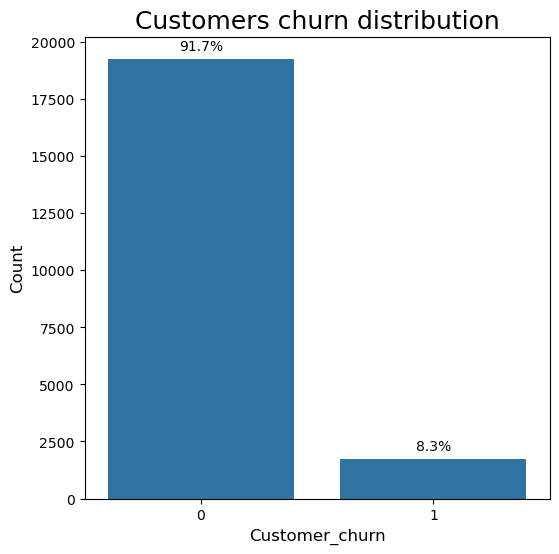

In [36]:
# Visualize churn distribution with percentage labels
plt.figure(figsize=(6, 6))

# Create the count plot
ax = sns.countplot(x=high_val_df['churn_probability'])

# Calculate percentages
total = high_val_df.shape[0]  # total number of customers
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)  # Calculate the percentage
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), textcoords='offset points', fontsize=10)  # Annotate the percentage

# Set labels and title
plt.xlabel('Customer_churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customers churn distribution', fontsize=18)

# Show plot
plt.show()

<pre>
Based on the above analysis, we can say that 91.73% of customers are non-churn, while 8.26% of customers churn. This indicates a noticeable class imbalance, which we will address later.

In [37]:
high_val_df.head(3)

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
4    240.708  128.191  101.565        21.28         4.83         6.13   
15   580.549  377.294  338.286        10.43        24.99       194.43   
23  1130.948  905.506  479.762       859.53       372.71         0.89   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
4          56.99         38.11          9.63          53.64            0.0   
15        317.11        341.79        197.09           0.00            0.0   
23        293.46        450.11        386.91           0.00            0.0   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
4             0.0          15.73            0.0            0.0   
15            0.0           0.00            0.0            0.0   
23            0.0           0.00            0.0            0.0   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
4              10.16              4.83              6.13             36.74   
15             10.43             24.99            194.43            313.76   
23            859.53            372.71              0.89             79.79   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
4              19.88              4.61             11.99              1.23   
15            330.88            185.88              3.26             10.91   
23            424.63            378.01             11.58             25.43   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
4               5.01               0.0              9.85               0.0   
15              4.94               0.0              0.00               0.0   
23              8.88               0.0              0.00               0.0   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
4          58.91         25.94         15.76               0.0   
15        327.46        366.79        385.26               0.0   
23        950.91        822.78        387.79               0.0   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
4                0.0               0.0              4.35               0.0   
15               0.0               0.0              0.00               0.0   
23               0.0               0.0            202.08               0.0   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
4                0.0               0.0               0.0              0.00   
15               0.0               0.0               0.0              6.26   
23               0.0               0.0               0.0              0.00   

    std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
4           4.35           0.0          0.00           0.0           0.0   
15          0.00           0.0          6.26           0.0           0.0   
23        202.08           0.0          0.00           0.0           0.0   

    isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
4            0.0          0.00         17.00          0.00          0.0   
15           0.0          0.08          0.00          0.00          0.1   
23           0.0          0.00          0.05          0.01          0.0   

    og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
4           0.0          0.0           63.26           42.94           15.76   
15          0.0          0.0          327.64          366.79          391.53   
23          0.0          0.0         1152.99          822.83          387.81   

    loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
4               5.44              1.39              2.66             10.58   
15             13.86             20.18            335.43            219.31   
23            233.28            117.63             30.39            123.78   

    loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_

In [38]:
# Create a copy of high_val_train df and use the new df (churn_data) for pruning in the training set
churn_data = high_val_df.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)

In [39]:
churn_data.shape

(20998, 149)

In [40]:
churn_data.head(3)

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   240.708  128.191  101.565        21.28         4.83         6.13   
1   580.549  377.294  338.286        10.43        24.99       194.43   
2  1130.948  905.506  479.762       859.53       372.71         0.89   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         56.99         38.11          9.63          53.64            0.0   
1        317.11        341.79        197.09           0.00            0.0   
2        293.46        450.11        386.91           0.00            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0          15.73            0.0            0.0   
1            0.0           0.00            0.0            0.0   
2            0.0           0.00            0.0            0.0   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0             10.16              4.83              6.13             36.74   
1             10.43             24.99            194.43            313.76   
2            859.53            372.71              0.89             79.79   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             19.88              4.61             11.99              1.23   
1            330.88            185.88              3.26             10.91   
2            424.63            378.01             11.58             25.43   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              5.01               0.0              9.85               0.0   
1              4.94               0.0              0.00               0.0   
2              8.88               0.0              0.00               0.0   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0         58.91         25.94         15.76               0.0   
1        327.46        366.79        385.26               0.0   
2        950.91        822.78        387.79               0.0   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0               0.0               0.0              4.35               0.0   
1               0.0               0.0              0.00               0.0   
2               0.0               0.0            202.08               0.0   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0               0.0               0.0              0.00   
1               0.0               0.0               0.0              6.26   
2               0.0               0.0               0.0              0.00   

   std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
0          4.35           0.0          0.00           0.0           0.0   
1          0.00           0.0          6.26           0.0           0.0   
2        202.08           0.0          0.00           0.0           0.0   

   isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
0           0.0          0.00         17.00          0.00          0.0   
1           0.0          0.08          0.00          0.00          0.1   
2           0.0          0.00          0.05          0.01          0.0   

   og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0          0.0          0.0           63.26           42.94           15.76   
1          0.0          0.0          327.64          366.79          391.53   
2          0.0          0.0         1152.99          822.83          387.81   

   loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
0              5.44              1.39              2.66             10.58   
1             13.86             20.18            335.43            219.31   
2            233.28            117.63             30.39            123.78   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
0              4.33             19.49  

In [41]:
# Fetching list of columns with missing values in the training set
miss_val = round(100*(churn_data.isnull().mean()), 2)
cols = miss_val.loc[miss_val>0]
impute_cols_num = list(cols.index)
len(impute_cols_num)

81

In [42]:
# Verifying number of values missing from the dataframe
drop_df = high_val_df.dropna() # removing Nan rows from the df
print(churn_data.shape[0] - drop_df.shape[0])

1061


#### Imputing the missing values using KNN Imputer 

<pre>
It is not a good idea to discard the missing values, as doing so will result in loss of valuable information. To deal with the missing values here, we will implement KNNImputer as an imputation technique.

KNNImputer (K-Nearest Neighbors Imputer) is a technique to handle missing values in a dataset by using the K-Nearest Neighbors algorithm to estimate and fill them. It works by identifying the k nearest neighbour of each data point with missing values, then averaging or taking a weighted average of available values from those neighbours to fill in the missing value. Therefore, this approach leverages the similarity between data points to estimate the missing values more accurately.

In [43]:
# Instantiating the imputer
imputer = KNNImputer() # keeping default vals n_neighbors : int, default=5, Number of neighboring samples to use for imputation.

In [44]:
# creating a separate dataframe with columns to be imputed
df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [45]:
%%time
# Imputing the missing values using KNN imputer instance
imp_df = imputer.fit_transform(df_num)

CPU times: total: 18.5 s
Wall time: 34.6 s


In [46]:
imp_df = pd.DataFrame(imp_df, columns=impute_cols_num)
imp_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0             10.16              4.83   
1            0.0            0.0             10.43             24.99   
2            0.0            0.0            859.53            372.71   
3            0.0            0.0             93.18             38.29   
4            0.0            0.0              8.58             11.48   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              6.13             36.74             19.88              4.61   
1            194.43            313.76            330.88            185.88   
2              0.89             79.79            424.63            378.01   
3             29.86            159.29            219.44             99.86   
4             12.68             96.91            149.44            157.23   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0             11.99              1.23              5.01               0.0   
1              3.26             10.91              4.94               0.0   
2             11.58             25.43              8.88               0.0   
3              0.00              0.00              0.00               0.0   
4             33.71              9.28             25.59               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              9.85              0.00         58.91         25.94   
1              0.00              0.00        327.46        366.79   
2              0.00              0.00        950.91        822.78   
3              0.00              0.36        252.48        257.74   
4              0.00              0.00        139.21        170.21   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         15.76               0.0               0.0               0.0   
1        385.26               0.0               0.0               0.0   
2        387.79               0.0               0.0               0.0   
3        129.73               0.0               0.0               0.0   
4        195.51               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0              4.35              0.00              0.00               0.0   
1              0.00              0.00              0.00               0.0   
2            202.08              0.00              0.00               0.0   
3            371.89            288.31            121.79               0.0   
4              2.53              0.00              0.00               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0              0.00          4.35          0.00   
1               0.0              6.26          0.00          0.00   
2               0.0              0.00        202.08          0.00   
3               0.0              0.00        371.89        288.31   
4               0.0              0.00          2.53          0.00   

   std_og_

In [47]:
# Merging the dataframes together post imputation
final_df = pd.concat([imp_df, churn_df], join='inner', axis=1)
final_df.head(3)

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0             10.16              4.83   
1            0.0            0.0             10.43             24.99   
2            0.0            0.0            859.53            372.71   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              6.13             36.74             19.88              4.61   
1            194.43            313.76            330.88            185.88   
2              0.89             79.79            424.63            378.01   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0             11.99              1.23              5.01               0.0   
1              3.26             10.91              4.94               0.0   
2             11.58             25.43              8.88               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              9.85               0.0         58.91         25.94   
1              0.00               0.0        327.46        366.79   
2              0.00               0.0        950.91        822.78   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         15.76               0.0               0.0               0.0   
1        385.26               0.0               0.0               0.0   
2        387.79               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0              4.35               0.0               0.0               0.0   
1              0.00               0.0               0.0               0.0   
2            202.08               0.0               0.0               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0              0.00          4.35           0.0   
1               0.0              6.26          0.00           0.0   
2               0.0              0.00        202.08           0.0   

   std_og_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  \
0          0.00           0.0           0.0           0.0          0.00   
1          6.26           0.0           0.0           0.0          0.08   
2          0.00           0.0           0.0           0.0          0.00   

   spl_og_mou_7  spl_og_mou_8  og_others_6  og_others_7  og_others_8  \
0         17.00          0.00          0.0          0.0          0.0   
1          0.00          0.00          0.1          0.0          0.0   
2          0.05          0.01          0.0          0.0          0.0   

   loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
0              5.44              1.39              2.66             10.58   
1             13.86             20.18            335.43            219.31   
2            233.28            117.63             30.39            123.78   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
0              4.33             19.49              5.51              3.63   
1            754.24            285.63              0.00              1.93   
2            278.49            148.83             34.31             52.08   

   loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0              6.14         21.54          9.36         28.31   


In [48]:
final_df.shape

(20998, 149)

In [49]:
type_null_checker(final_df)

Number of "object" columns/features: 0
Number of "int64" columns/features: 25
Number of "float64" columns/features: 117
No columns with null values


In [50]:
# Imputing missing values on test set now using KNNImputer
# Separate df having columns to be imputed
df_num_unseen = telecom_test_df[impute_cols_num]
churn_df_unseen = telecom_test_df.drop(impute_cols_num, axis=1)

In [51]:
%%time
# Impute using KNN imputer instance
imp_df_test = imputer.transform(df_num_unseen)

CPU times: total: 56.3 s
Wall time: 1min 47s


In [52]:
# Convert it to df post imputation
imp_df_test = pd.DataFrame(imp_df_test, columns=impute_cols_num)
imp_df_test.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00             24.88             20.23   
1           0.00           0.00             75.51             41.21   
2          53.68          54.44              0.00              0.00   
3           0.00           0.00              5.31              0.00   
4           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             21.06             18.13             10.89              8.36   
1             19.84            473.61            598.08            377.26   
2              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51   
4             14.56              2.39              2.66             10.94   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00             13.58              0.00               0.0   
1              0.73              0.00              0.00               0.0   
2              0.00              0.00              0.00               0.0   
3              0.00              0.00              2.35               0.0   
4              0.00              0.00              0.00               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.03         43.01         44.71   
1              0.00              0.00        549.86        639.29   
2              0.00              0.00          0.00          0.00   
3              6.18              0.00          8.26         98.61   
4              0.00              0.00          2.84          3.44   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         29.43              6.90              0.00              2.05   
1        397.11              0.00              0.00              0.00   
2          0.00              0.00              0.00              0.00   
3         22.86              0.00              2.16              0.00   
4         25.51            450.48            608.24            686.11   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             42.03              7.68             26.43               0.0   
1              0.00             23.76             17.68               0.0   
2              0.00              0.00              0.00               0.0   
3             37.09             94.36              0.00               0.0   
4             58.54             21.18             63.18               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         48.93          7.68   
1               0.0               0.0          0.00         23.76   
2               0.0               0.0          0.00          0.00   
3               0.0               0.0         37.09         96.53   
4               0.0               0.0        509.03        629.43   

   std_og_

In [53]:
# Merge the two dataframes together post imputation
final_test_df = pd.concat([imp_df_test, churn_df_unseen], join='inner', axis=1)
final_test_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00             24.88             20.23   
1           0.00           0.00             75.51             41.21   
2          53.68          54.44              0.00              0.00   
3           0.00           0.00              5.31              0.00   
4           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             21.06             18.13             10.89              8.36   
1             19.84            473.61            598.08            377.26   
2              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51   
4             14.56              2.39              2.66             10.94   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00             13.58              0.00               0.0   
1              0.73              0.00              0.00               0.0   
2              0.00              0.00              0.00               0.0   
3              0.00              0.00              2.35               0.0   
4              0.00              0.00              0.00               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.03         43.01         44.71   
1              0.00              0.00        549.86        639.29   
2              0.00              0.00          0.00          0.00   
3              6.18              0.00          8.26         98.61   
4              0.00              0.00          2.84          3.44   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         29.43              6.90              0.00              2.05   
1        397.11              0.00              0.00              0.00   
2          0.00              0.00              0.00              0.00   
3         22.86              0.00              2.16              0.00   
4         25.51            450.48            608.24            686.11   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             42.03              7.68             26.43               0.0   
1              0.00             23.76             17.68               0.0   
2              0.00              0.00              0.00               0.0   
3             37.09             94.36              0.00               0.0   
4             58.54             21.18             63.18               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         48.93          7.68   
1               0.0               0.0          0.00         23.76   
2               0.0               0.0          0.00          0.00   
3               0.0               0.0         37.09         96.53   
4               0.0               0.0        509.03        629.43   

   std_og_

In [54]:
final_test_df.shape

(30000, 149)

In [55]:
type_null_checker(final_test_df)

Number of "object" columns/features: 0
Number of "int64" columns/features: 26
Number of "float64" columns/features: 117
No columns with null values


#### Function declerations for Data visualization and evaluations

In [56]:
def plot_bar_graph(title, month, y_list, data):
    '''
    Plot bar graphs for given data.

    Parameters:
        - title (str): Title of the plot.
        - month (list of str): List of month names.
        - y_list (list of str): List of y-variable names corresponding to each month.
        - data (DataFrame): DataFrame containing the data to be plotted.

    Returns:
        - None

    This function plots bar graphs for each month's data based on the provided y-variables.
    It creates subplots for each month, with the corresponding y-variable plotted against 'churn_probability'.
    The title of each subplot includes the specified title along with the month name.
    '''
    plt.figure(figsize=(12,10))
    for i, m in enumerate(month):
        plt.subplot(2,3,i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
        
    plt.tight_layout()
    plt.show()

In [57]:
def outlier_handling(dataframe):
    '''
     Applies outlier handling transformations to the values in the given DataFrame.

    Parameters:
        - dataframe (DataFrame): The DataFrame containing the values to be transformed.

    Returns:
        - transformed_values (list): A list containing the transformed values based on the specified conditions.
    '''
    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value))) #np.log1p(value),commonly used to handle skewed data. 
            
    return transformed_values

In [58]:
def classification_metrics_calculator(y_true, y_pred):
    '''
    Calculate various classification metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: A DataFrame containing the calculated metrics.
    '''
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix\n\n',cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1,1]
    FP = cm[0,1]
    TN = cm[0,0]
    FN = cm[1,0]
    
    # Accuracy score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)
    
    # Sensitivity [Recall or True Postive Rate]
    sensitivity = round(TP / (TP + FN), 4)
    
    # Specificity 
    specificity = round(TN / (TN + FP), 4)
    
    # Precision
    precision = round(TP / (TP + FP), 4)
    
    # False Positive Rate (1-Specificity )
    false_positive_rate = round(FP / (FP + TN), 4)
    
    # True Positive Rate
    true_positive_rate = sensitivity
    
    metric_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })
    
    return metric_df

In [59]:
def plot_roc(actual, probs):
    '''
    Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) score.

    Parameters:
    ----------
    actual : array-like
        True binary labels (0 or 1) for the target variable.
    probs : array-like
        Predicted probabilities of the positive class (usually between 0 and 1).
    
    Returns:
    -------
    tuple:
        - fpr (array): False Positive Rates computed for different threshold values.
        - tpr (array): True Positive Rates computed for different threshold values.
        - thresholds (array): Threshold values used to compute the FPR and TPR.
    
    The function performs the following:
    -----------------------------------
    1. Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at various threshold levels using the `roc_curve` function.
    2. Computes the Area Under the ROC Curve (AUC) score to evaluate overall model performance.
    3. Plots the ROC curve with FPR on the x-axis and TPR on the y-axis.
    4. Adds a diagonal reference line to indicate a model with no discriminatory ability.
    5. Returns the calculated FPR, TPR, and thresholds.

    Example usage:
    --------------
    >>> fpr, tpr, thresholds = draw_roc(y_true, predicted_probabilities)
    >>> print("AUC score:", auc_score)
    '''
    fpr, tpr, thresholds = roc_curve(actual, probs, drop_intermediate=False) # drop_intermediate, Whether to drop some suboptimal thresholds which would not appear
                                                                        # on a plotted ROC curve. This is useful in order to create lighter
                                                                        # ROC curves.
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr, thresholds

In [60]:
sorted(final_df.columns.to_list())

['aon',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'aug_vbc_3g',
 'churn_probability',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t

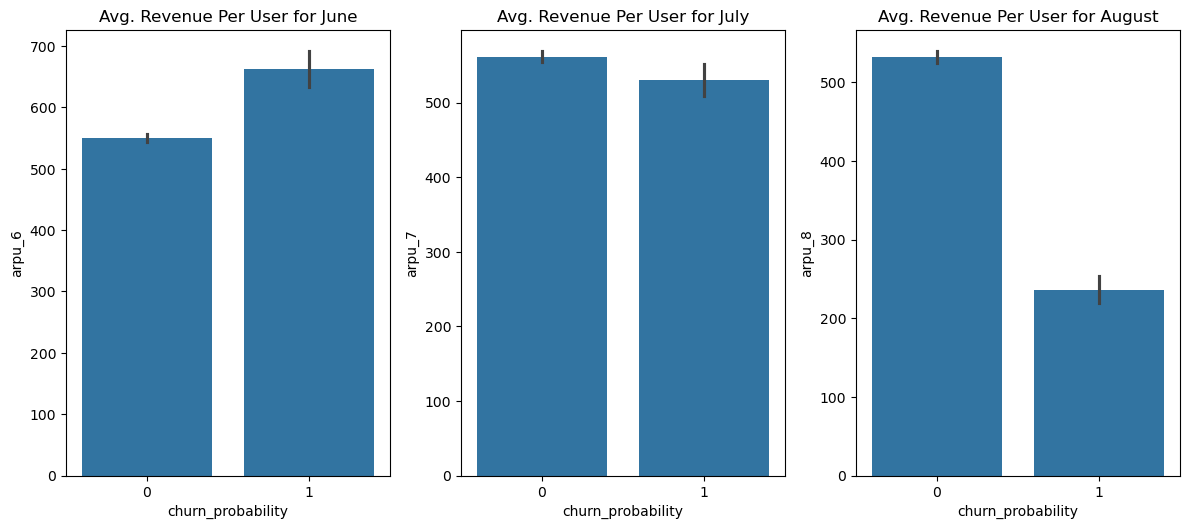

In [61]:
# Visualizing Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User',['June','July','August'], arpu_cols, final_df)

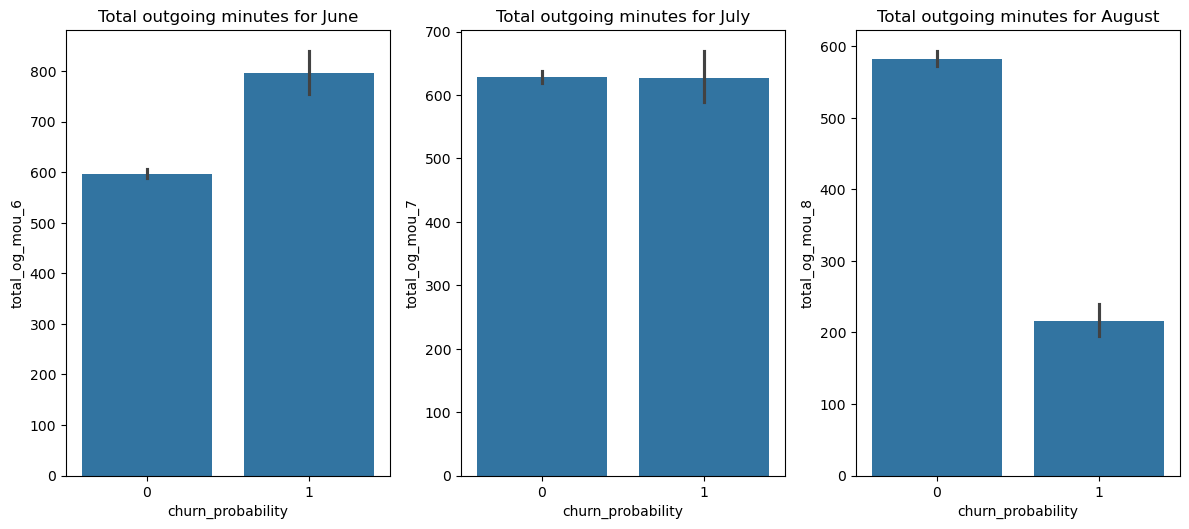

In [62]:
# Visualising Outgoing minutes usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

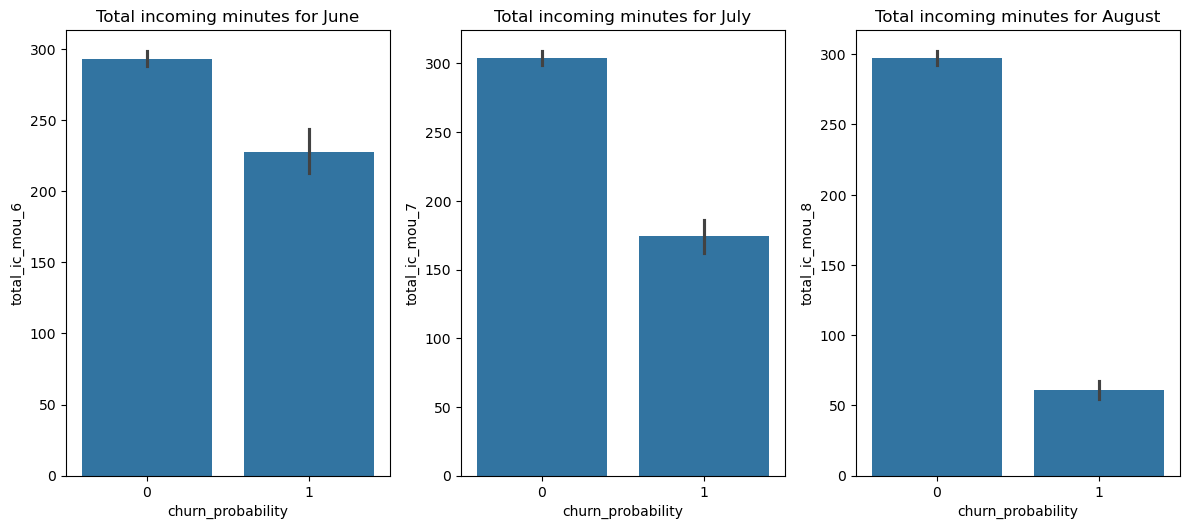

In [63]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_df)

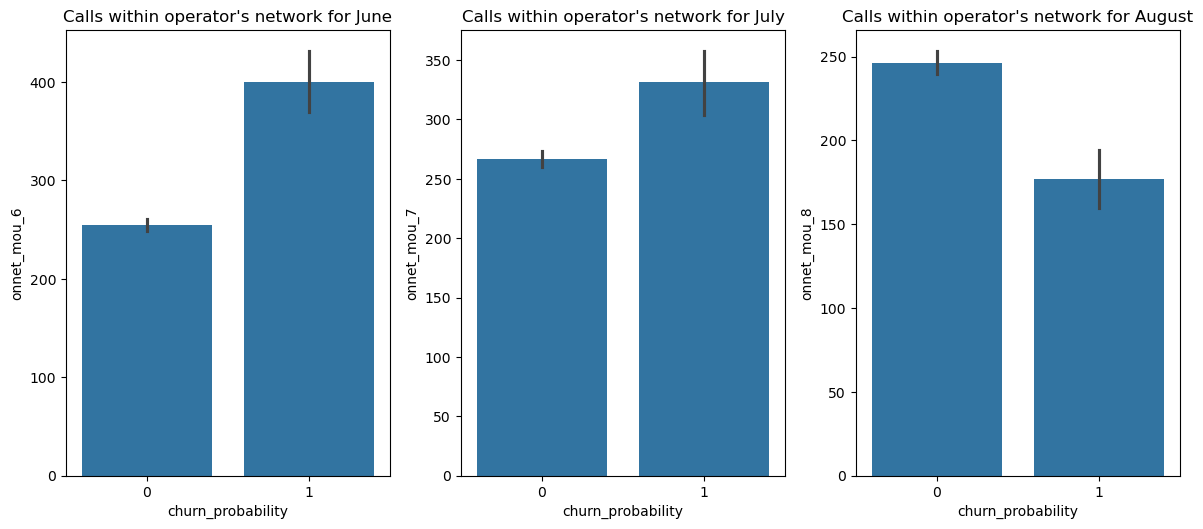

In [64]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
plot_bar_graph("Calls within operator's network", ['June', 'July', 'August'], onnet_mou_cols, final_df)

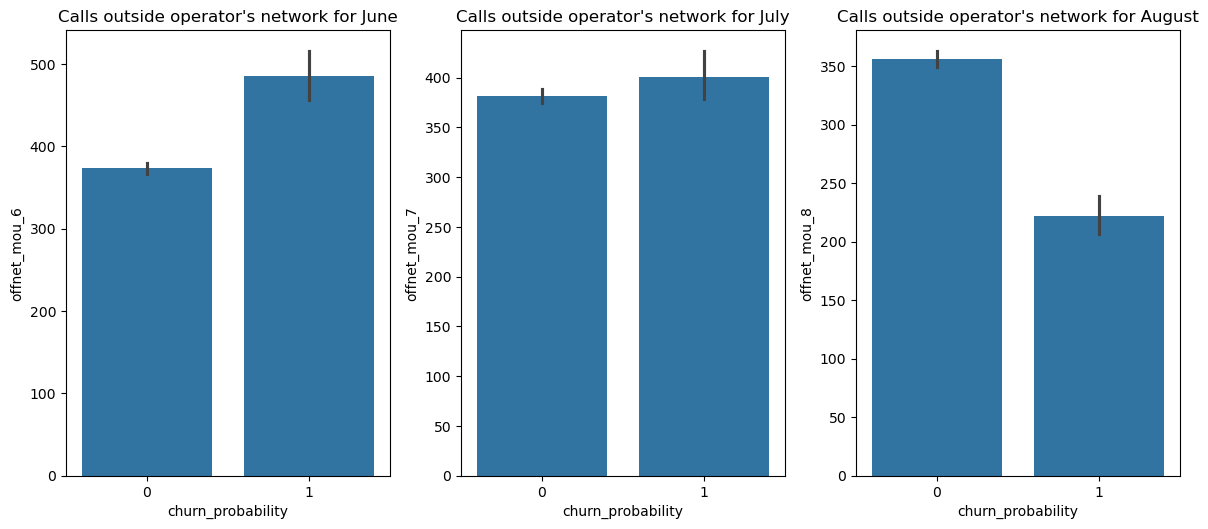

In [65]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph("Calls outside operator's network", ['June', 'July', 'August'], offnet_mou_cols, final_df)

The plots indicate a clear pattern of churn linked to declining user activity in August:

1. A noticeable drop in Average Revenue Per User (ARPU) in August is a strong indicator of churn.
2. A reduction in total outgoing minutes during August further signals potential churn.
3. Similarly, the decline in total incoming minutes in the same month suggests a likelihood of churn.
4. Calls within the operator's network also decreased in August, pointing toward churn behavior.
5. A reduction in calls outside the operator's network during August reinforces the churn trend.

In [66]:
# Analysing different features by clubbing columns of similar type

amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data_2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data_3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]

Analyzing correlation in Amount Data



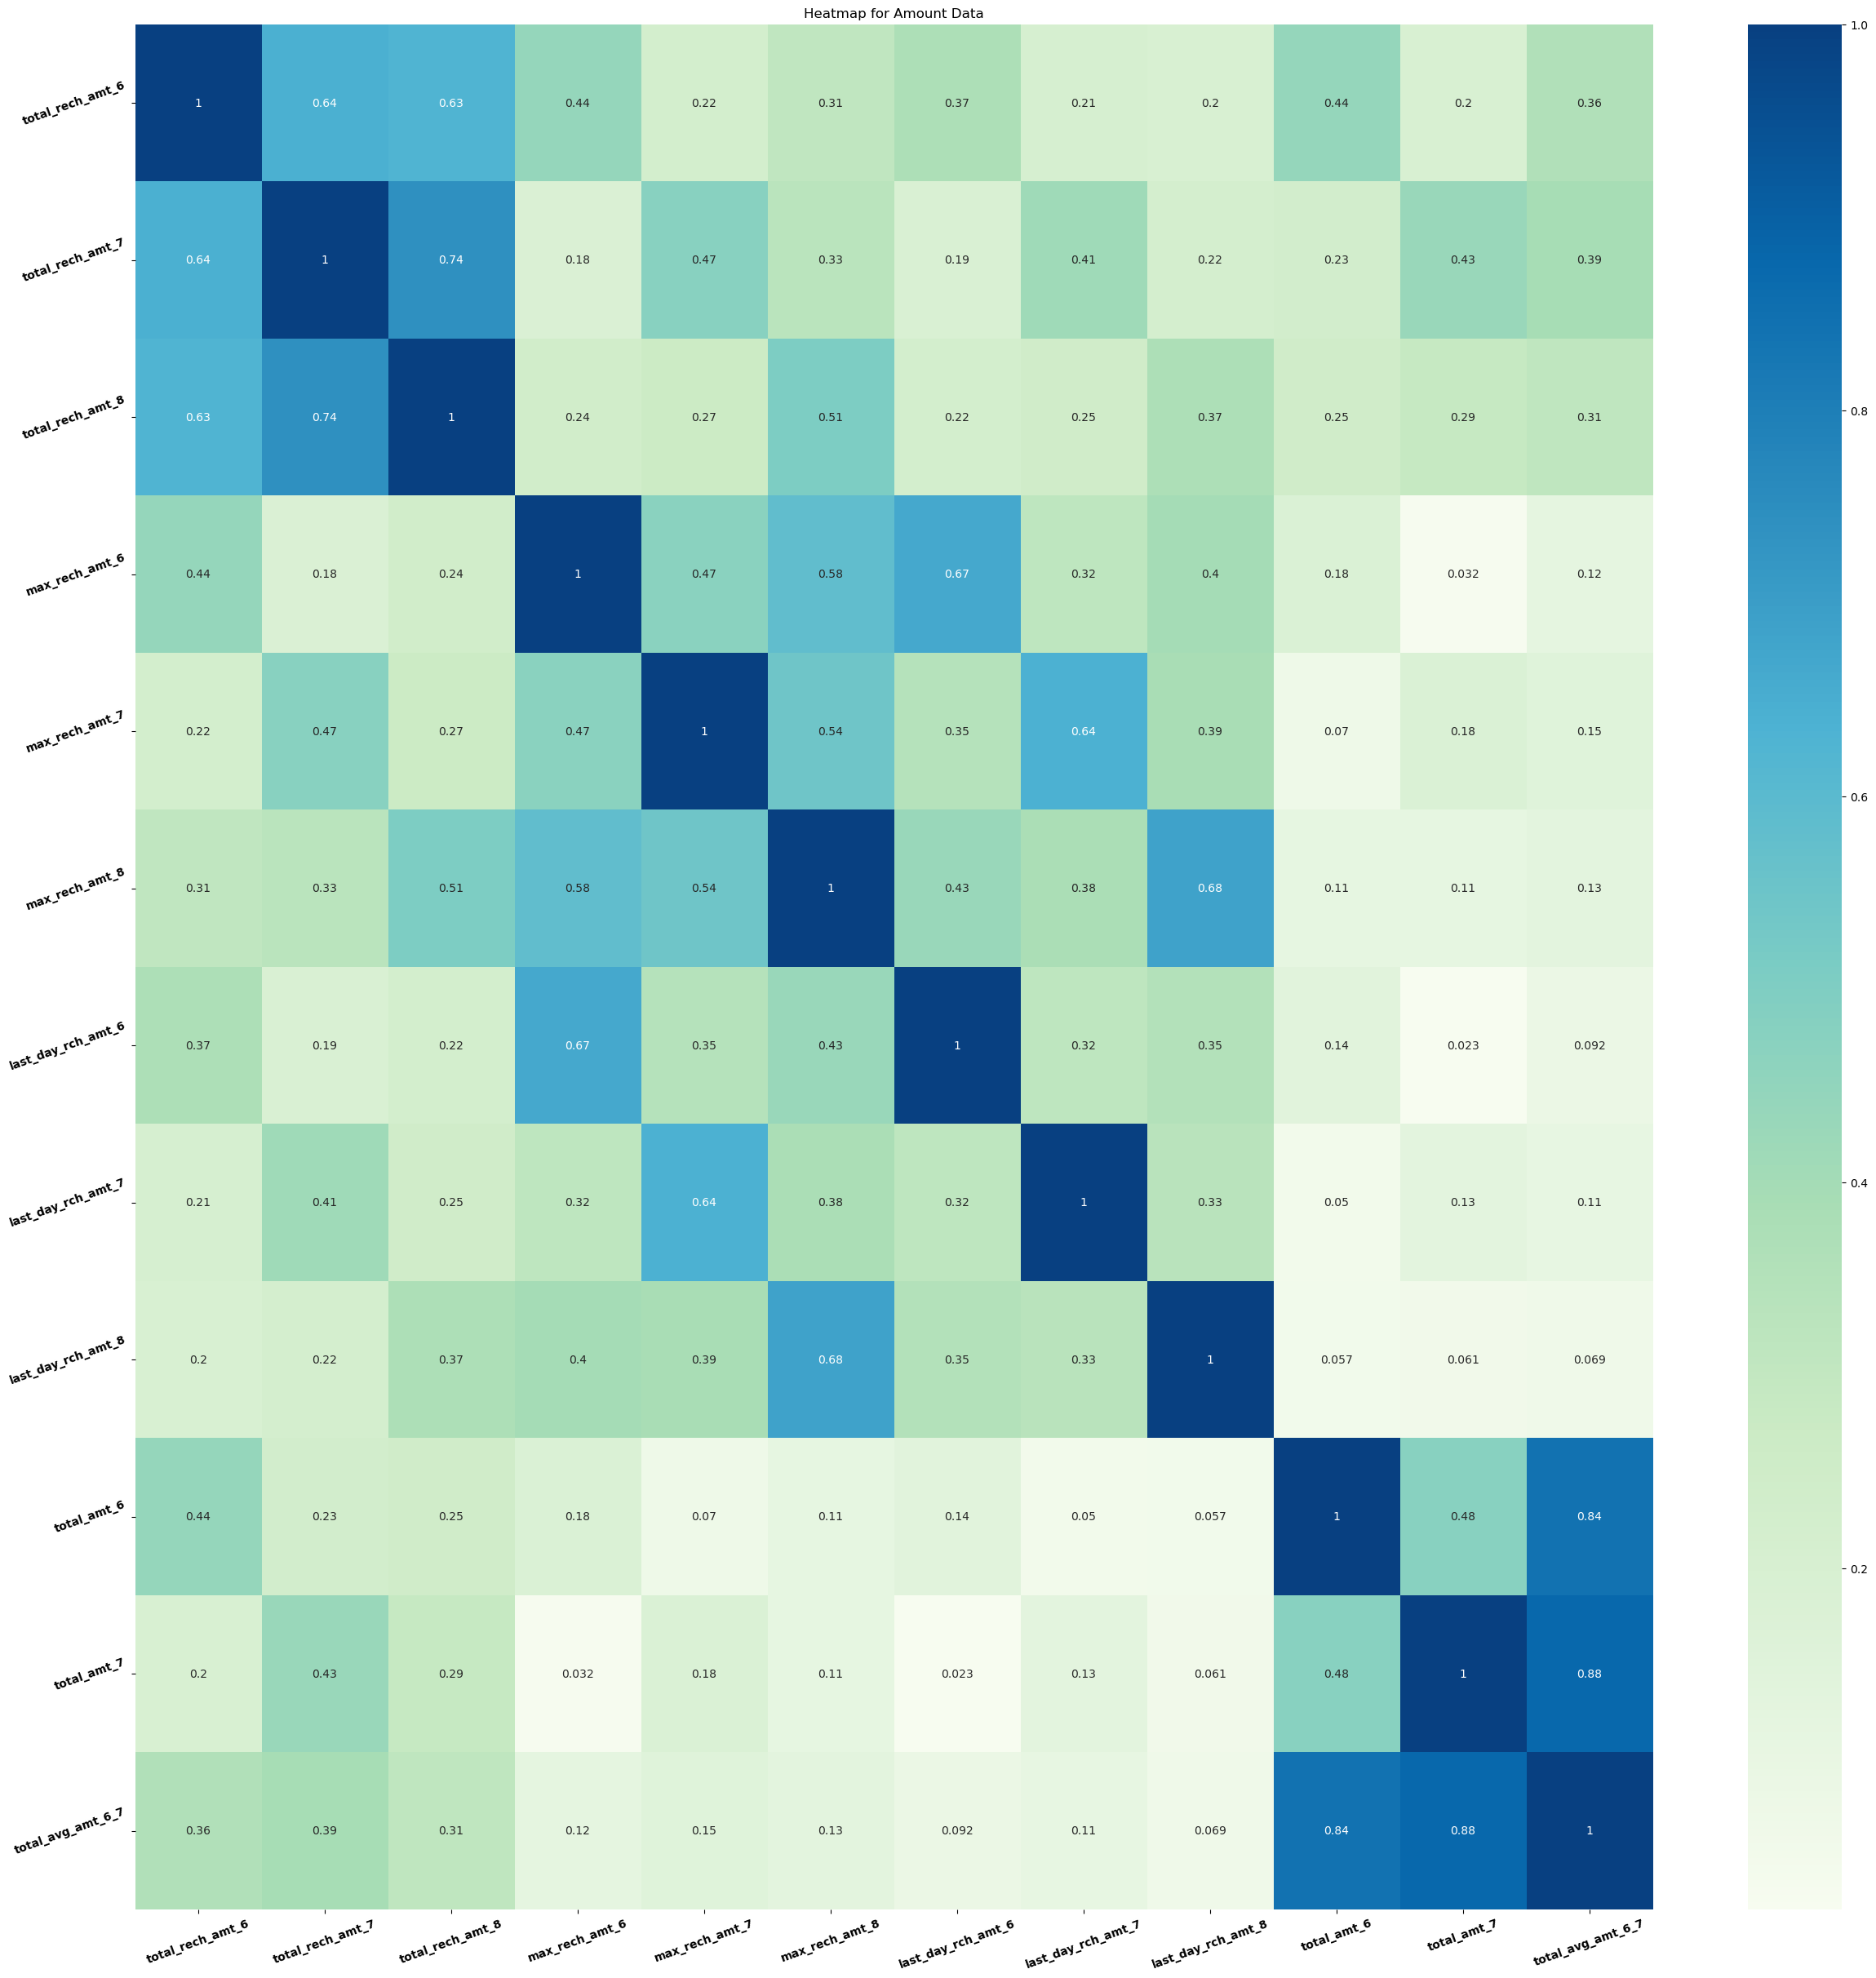

Analyzing correlation in 2G Data



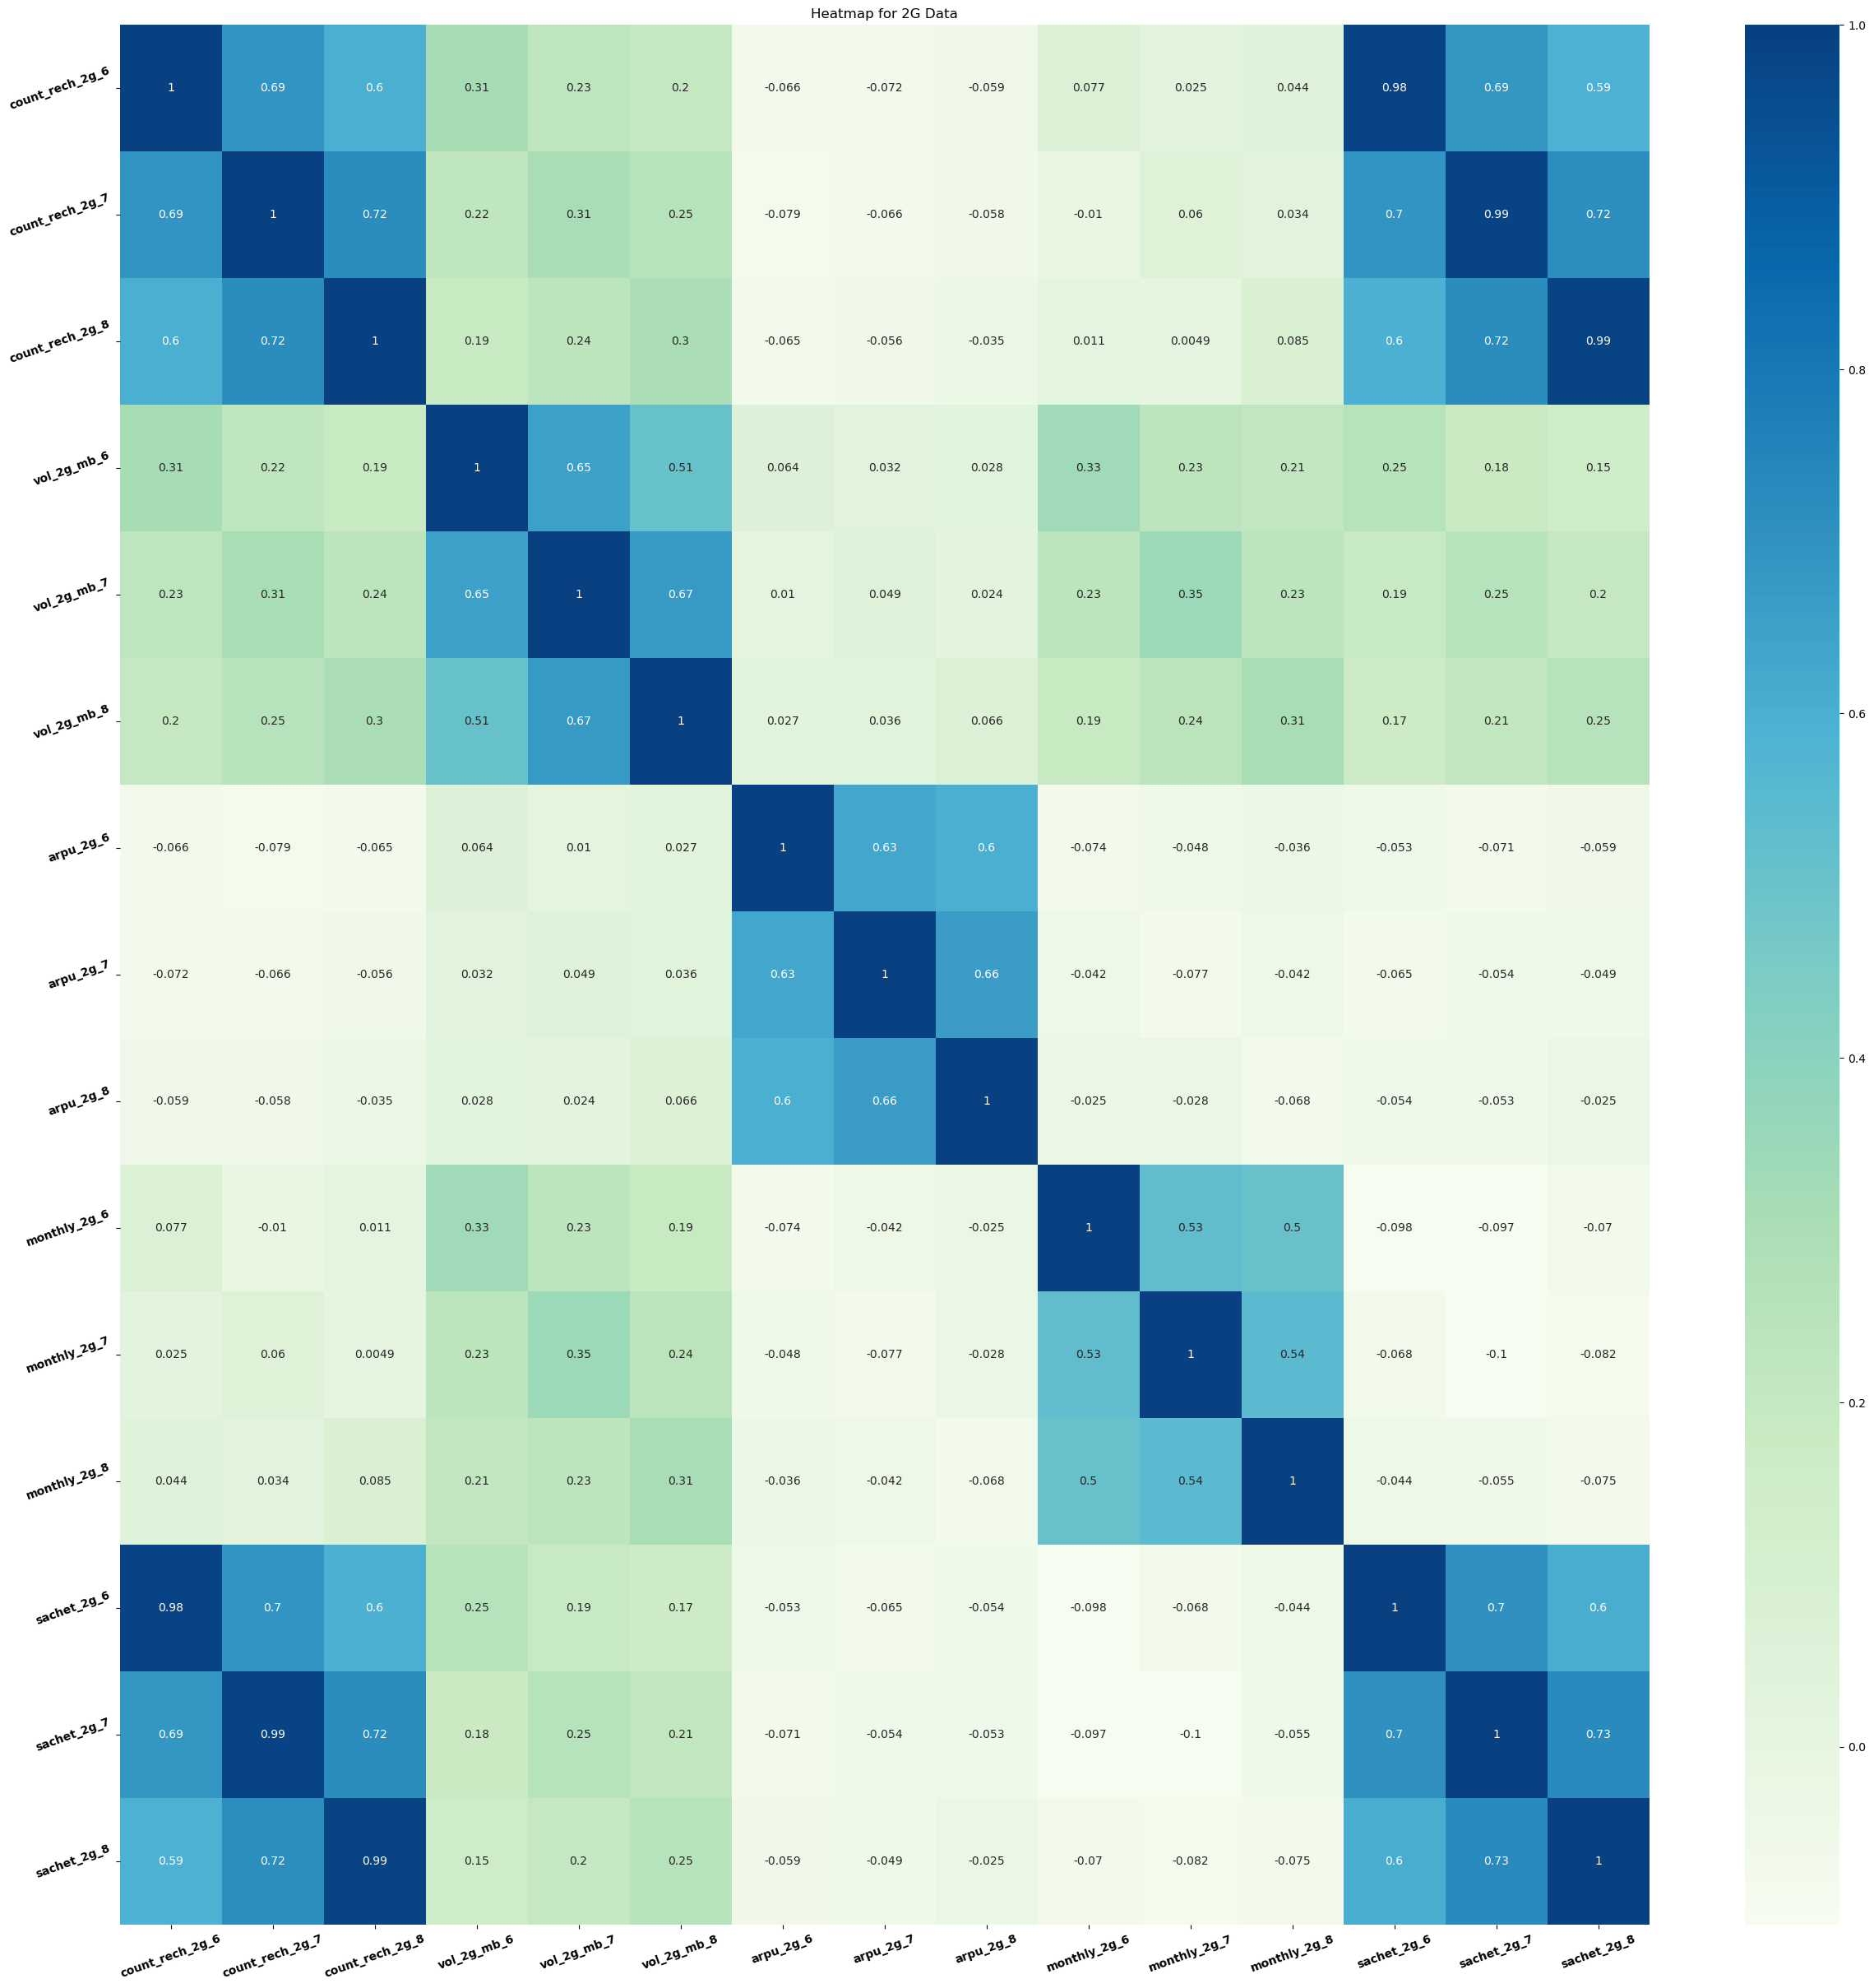

Analyzing correlation in 3G Data



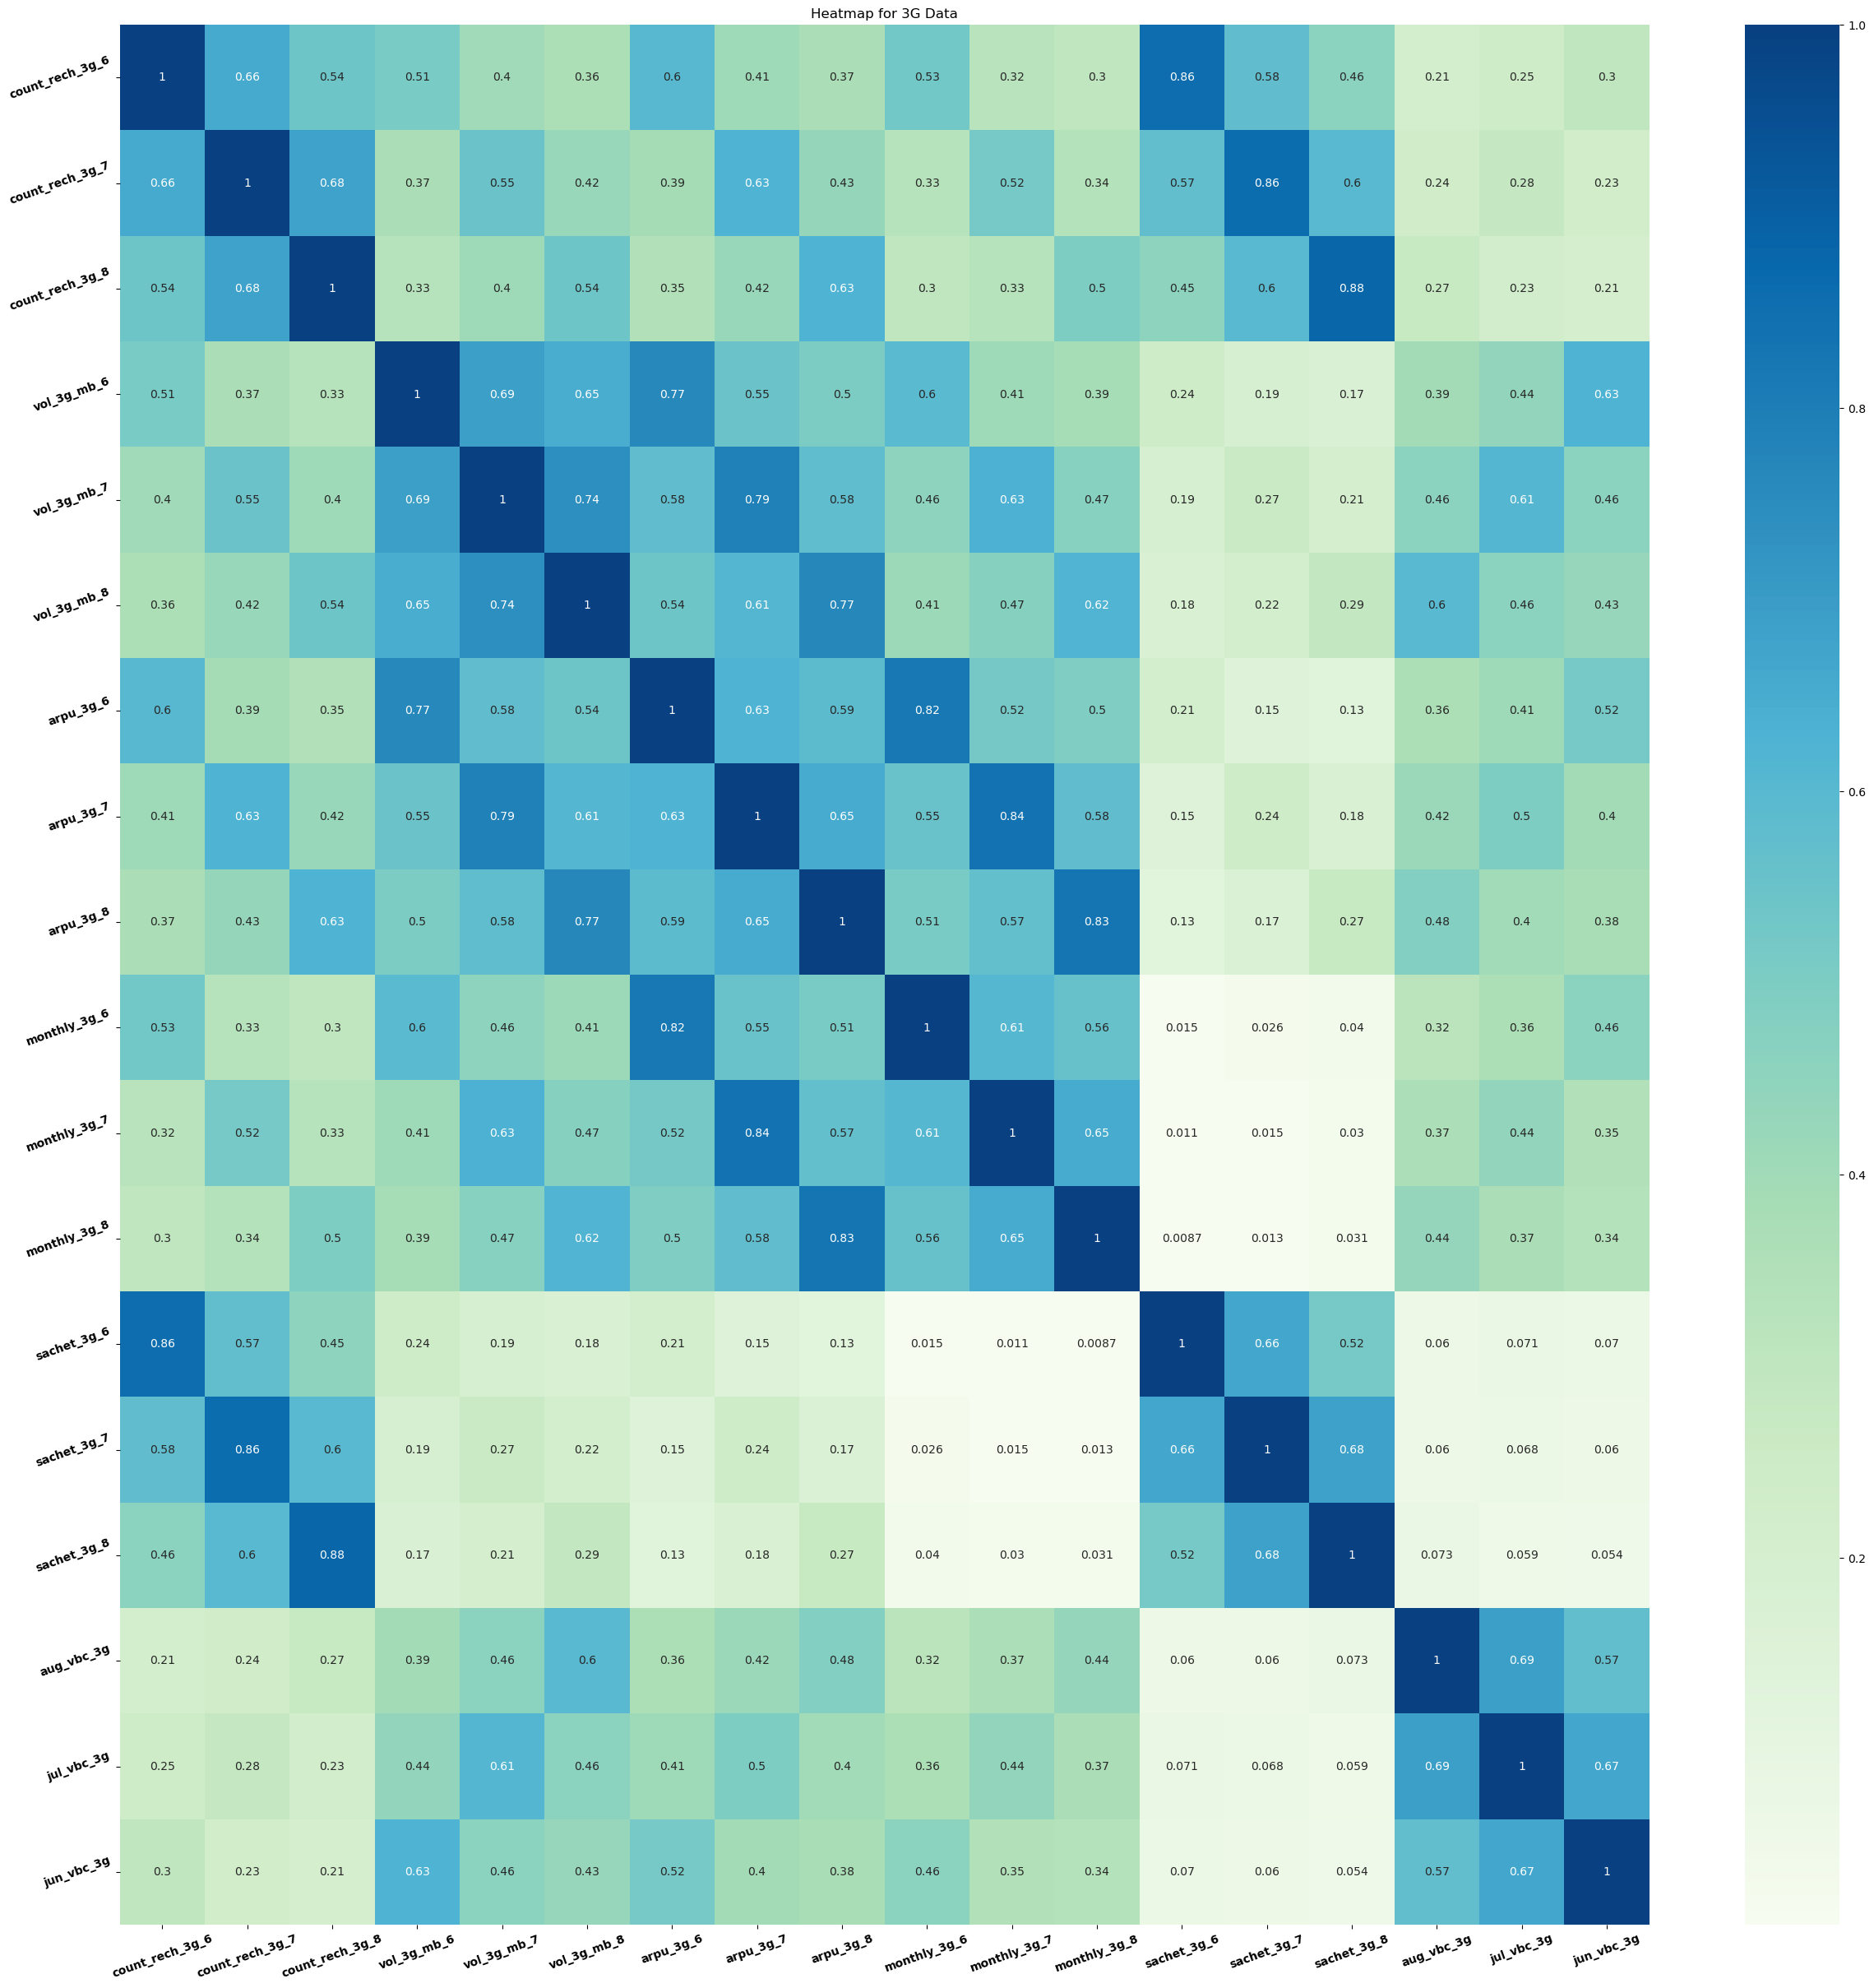

Analyzing correlation in Incoming Call Minutes (IC MOU)



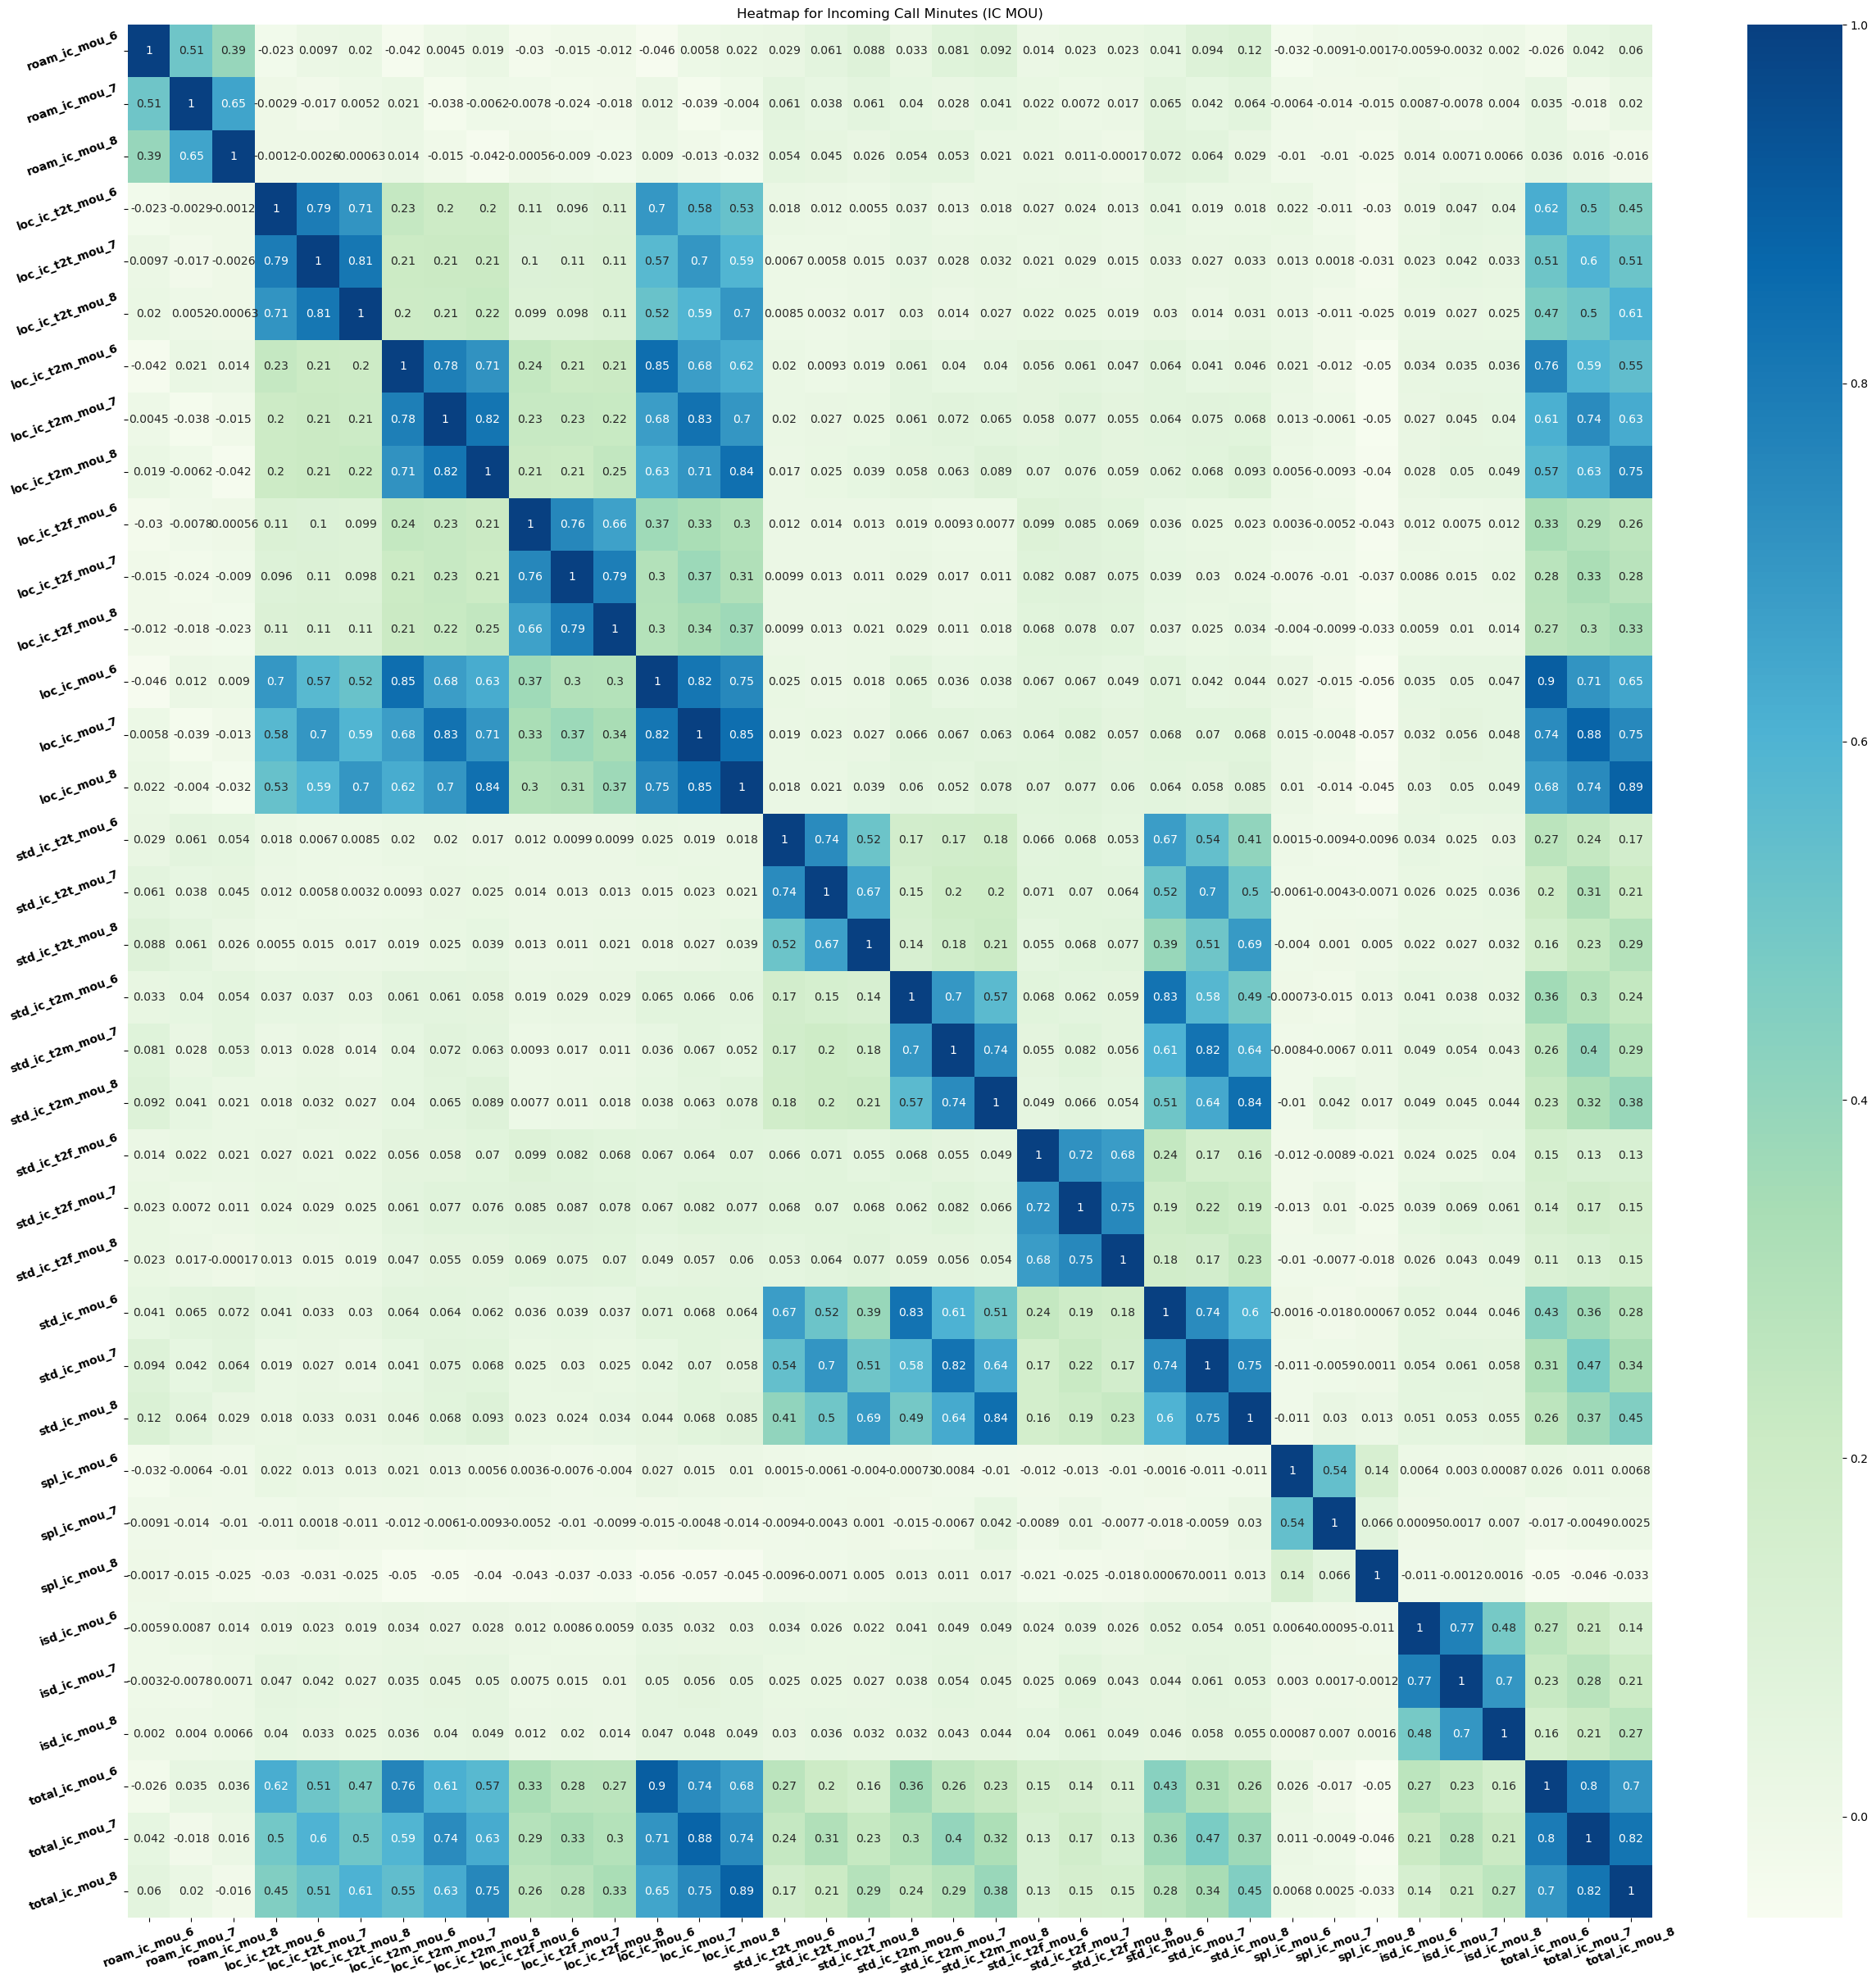

Analyzing correlation in Network Minutes (Net MOU)



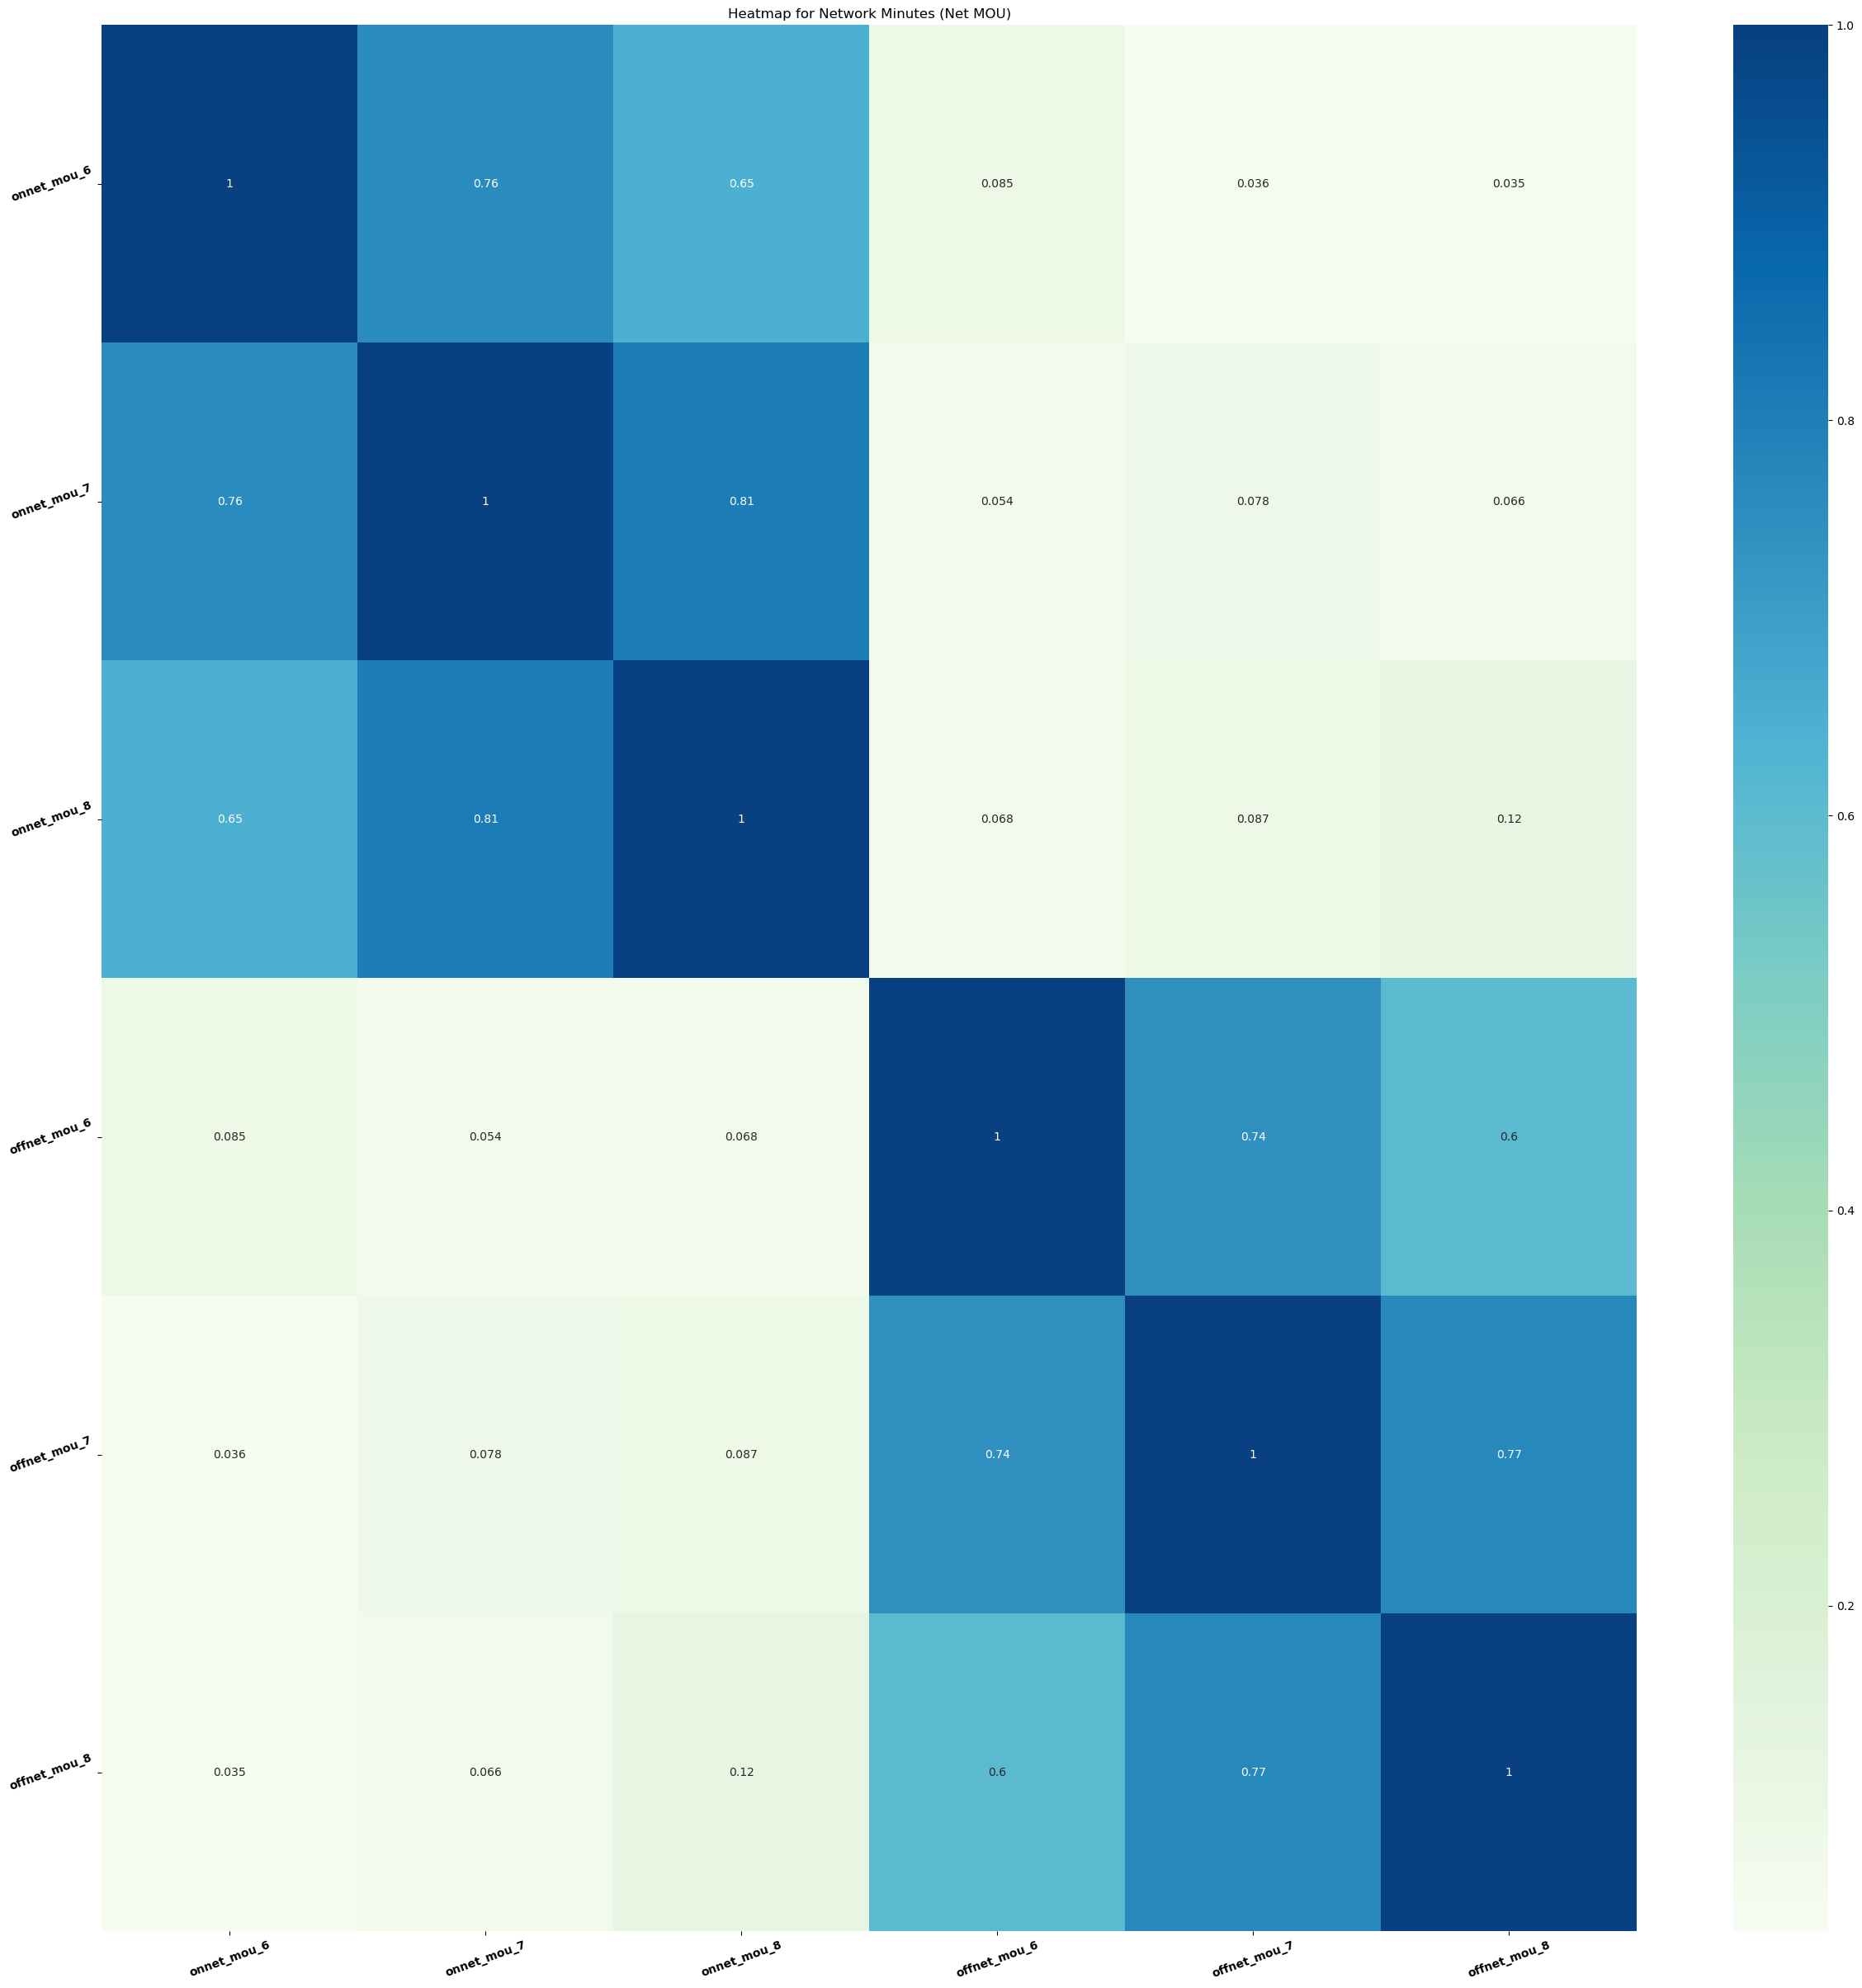

Analyzing correlation in Outgoing Call Minutes (OG MOU)



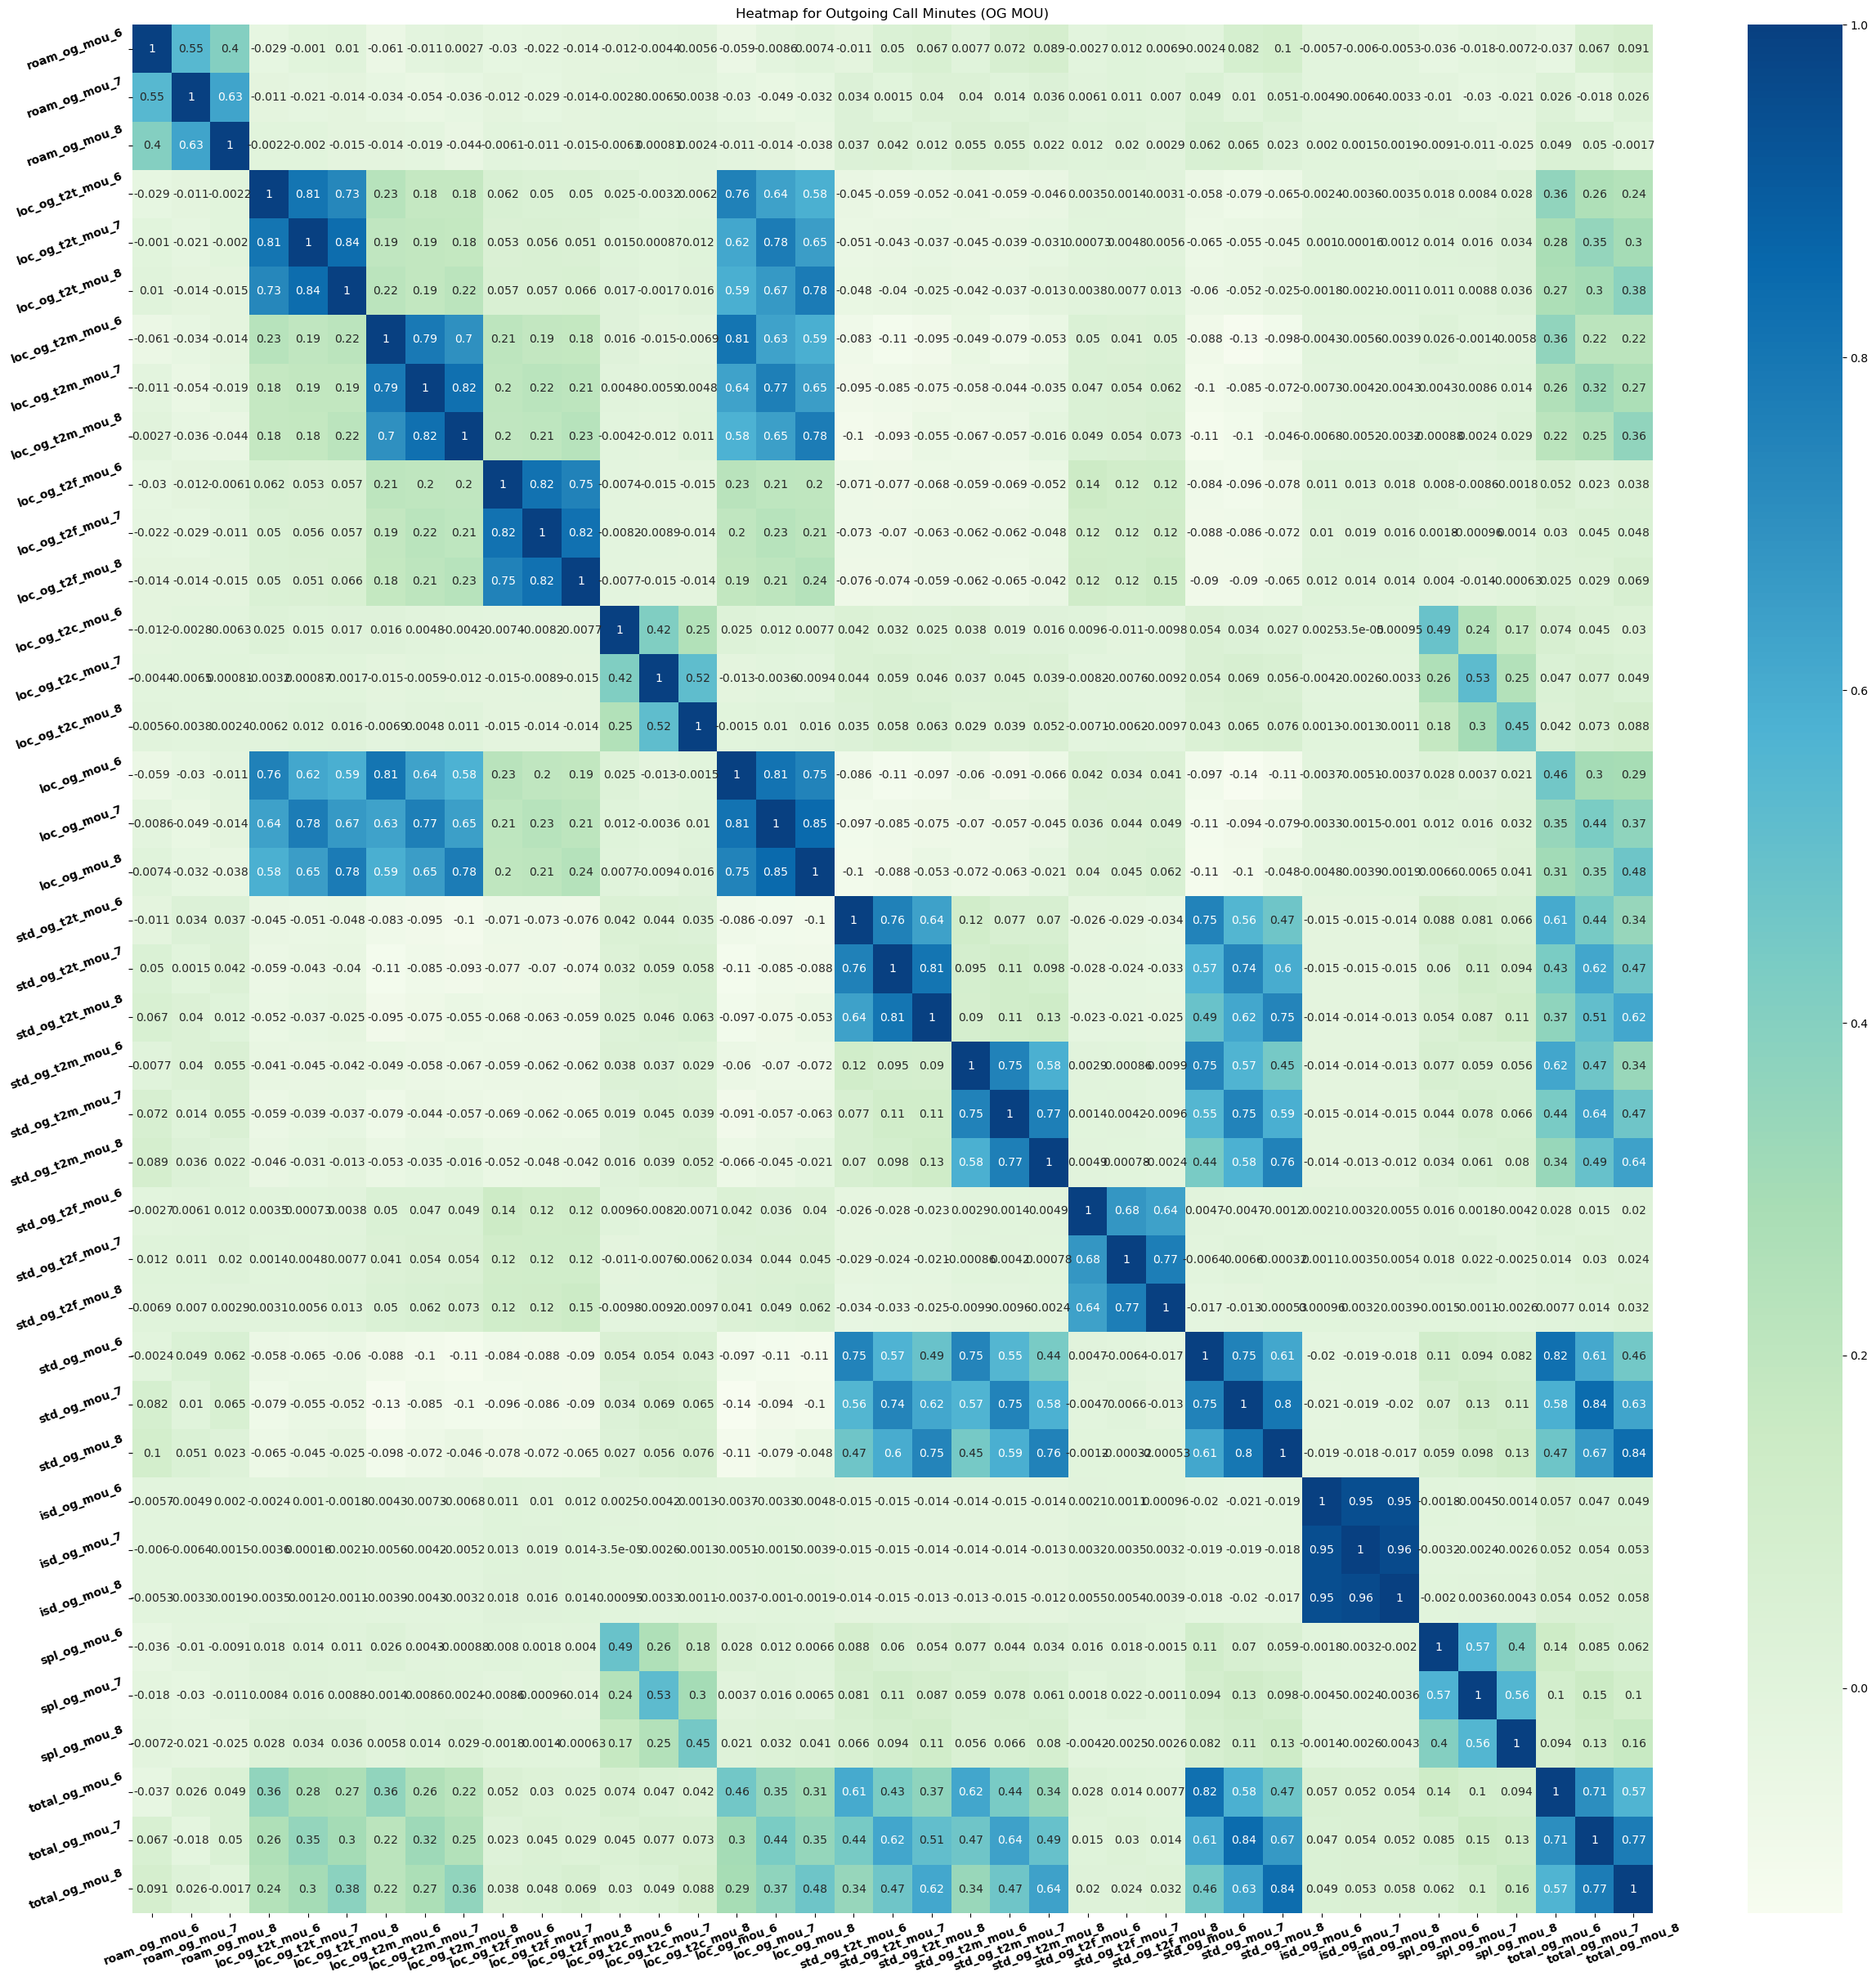

Analyzing correlation in Recharge Data



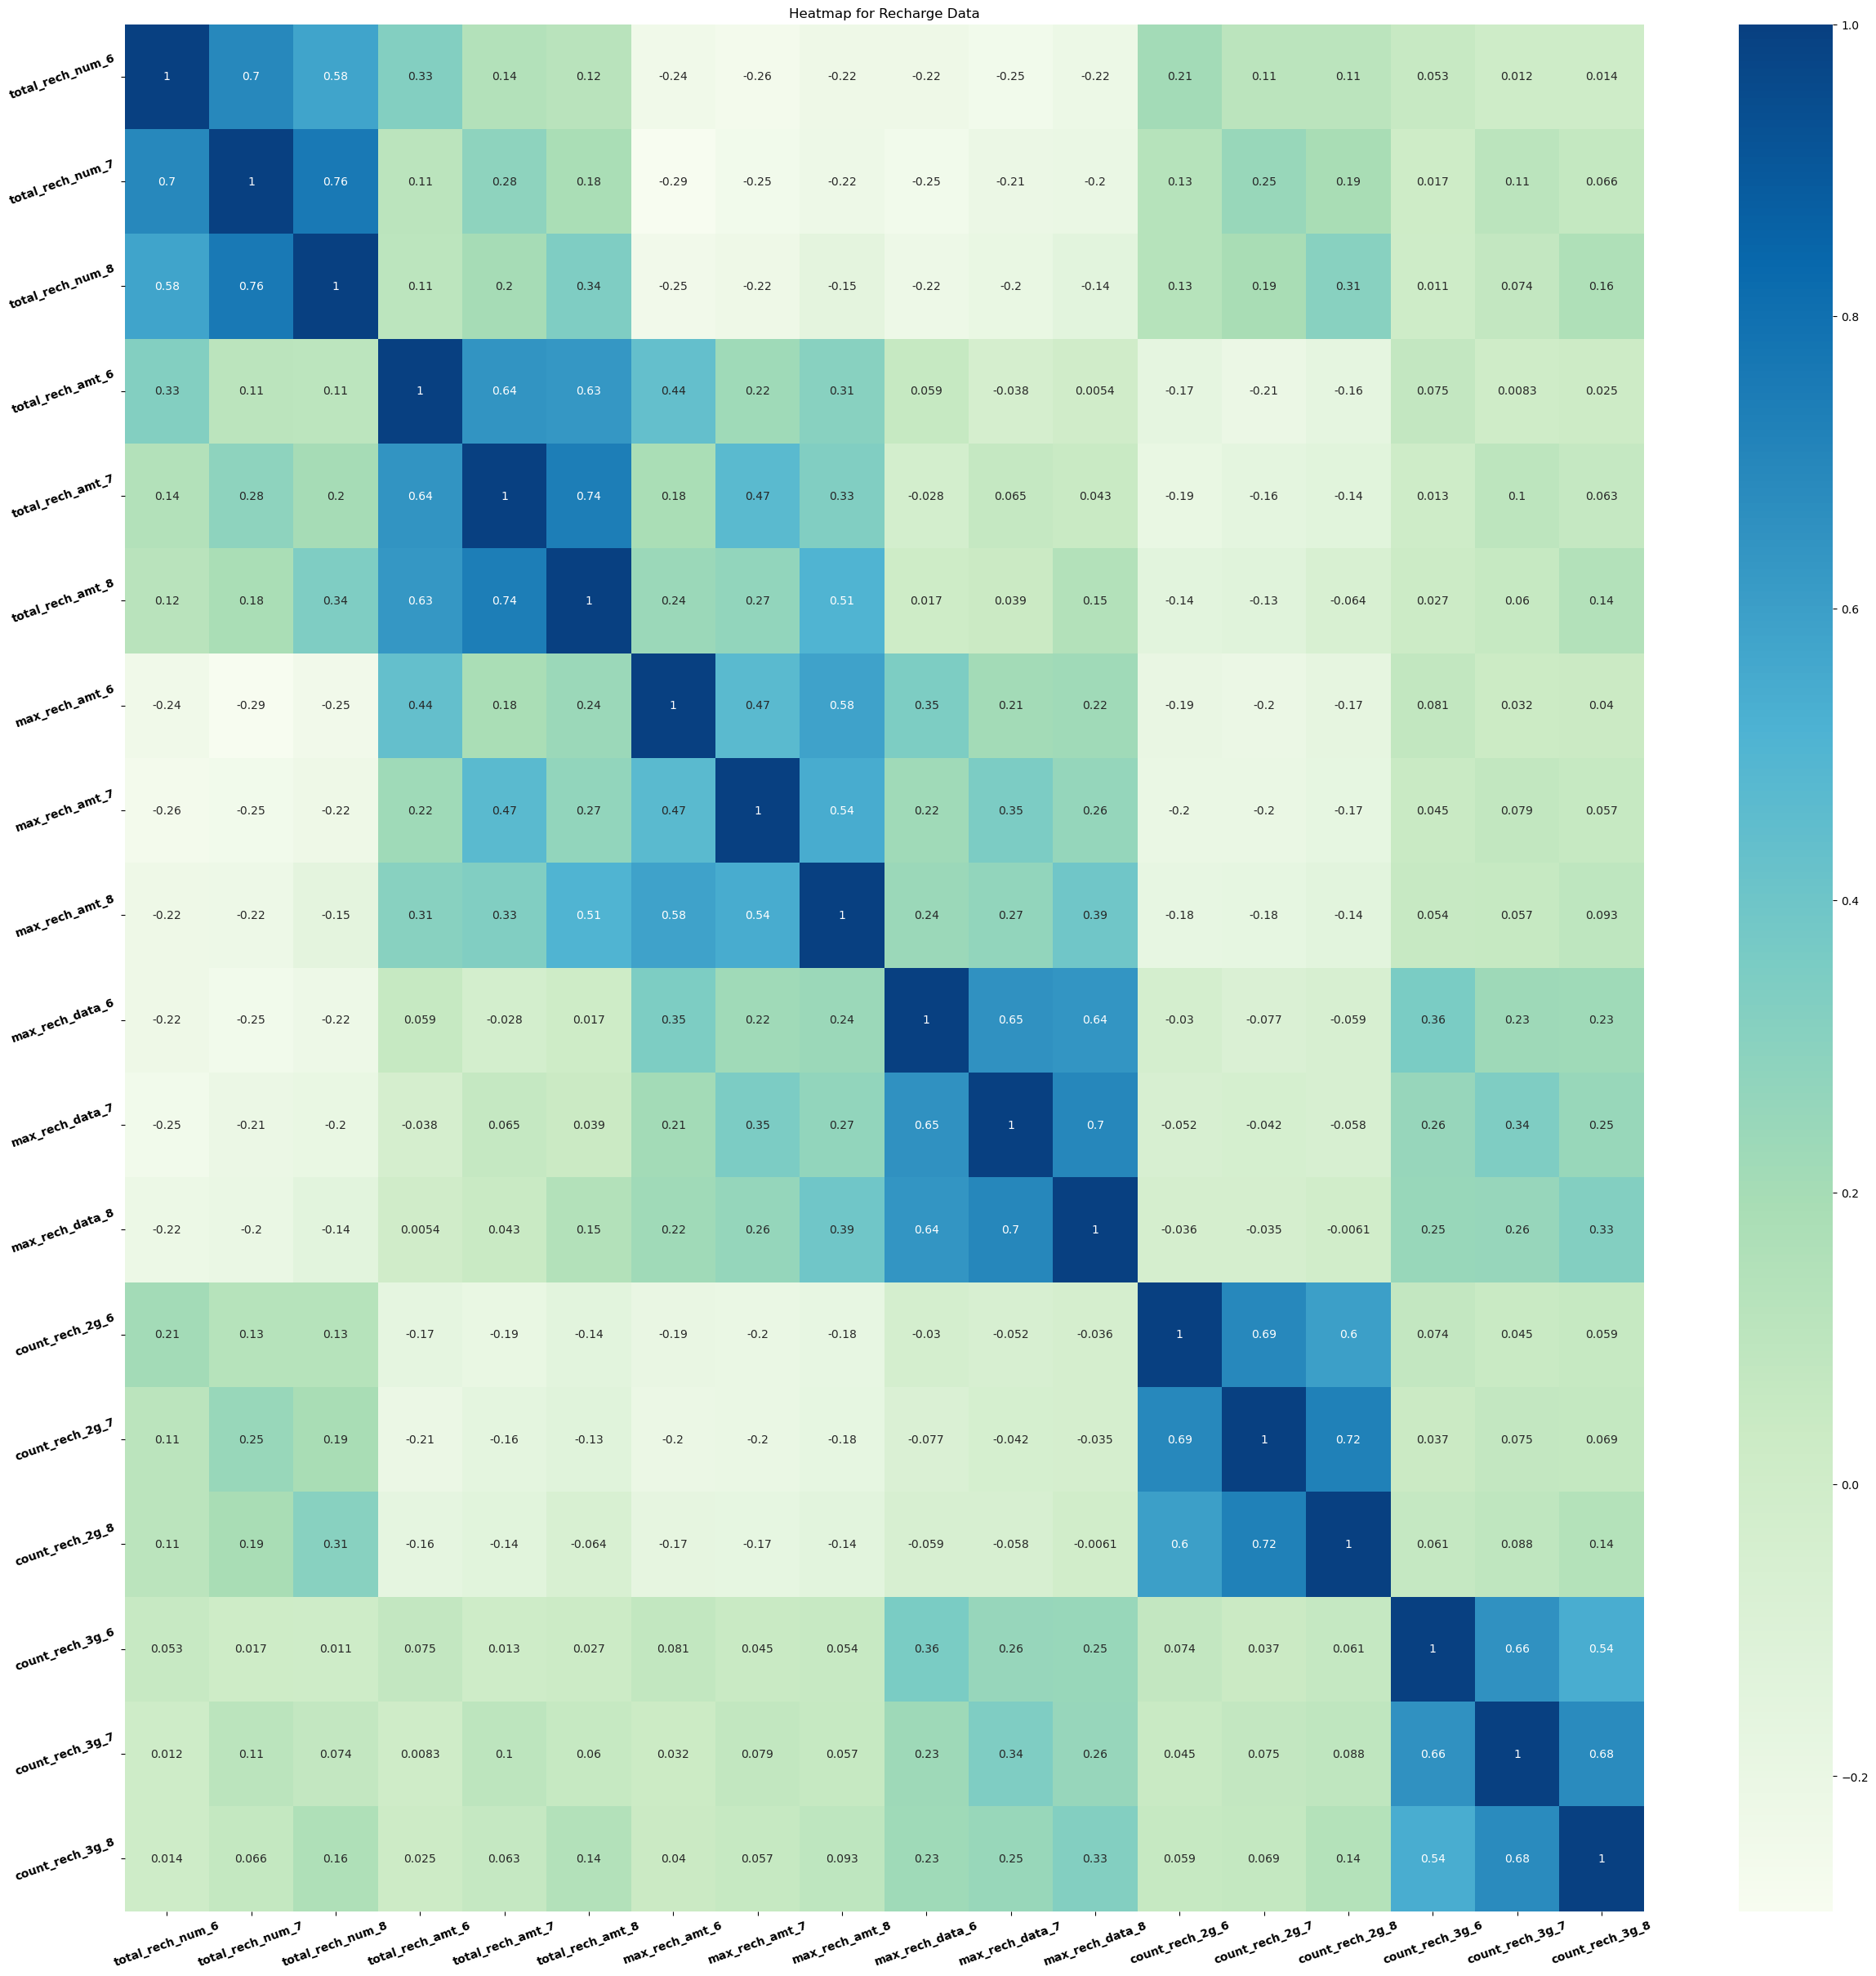

Analyzing correlation in Total Data



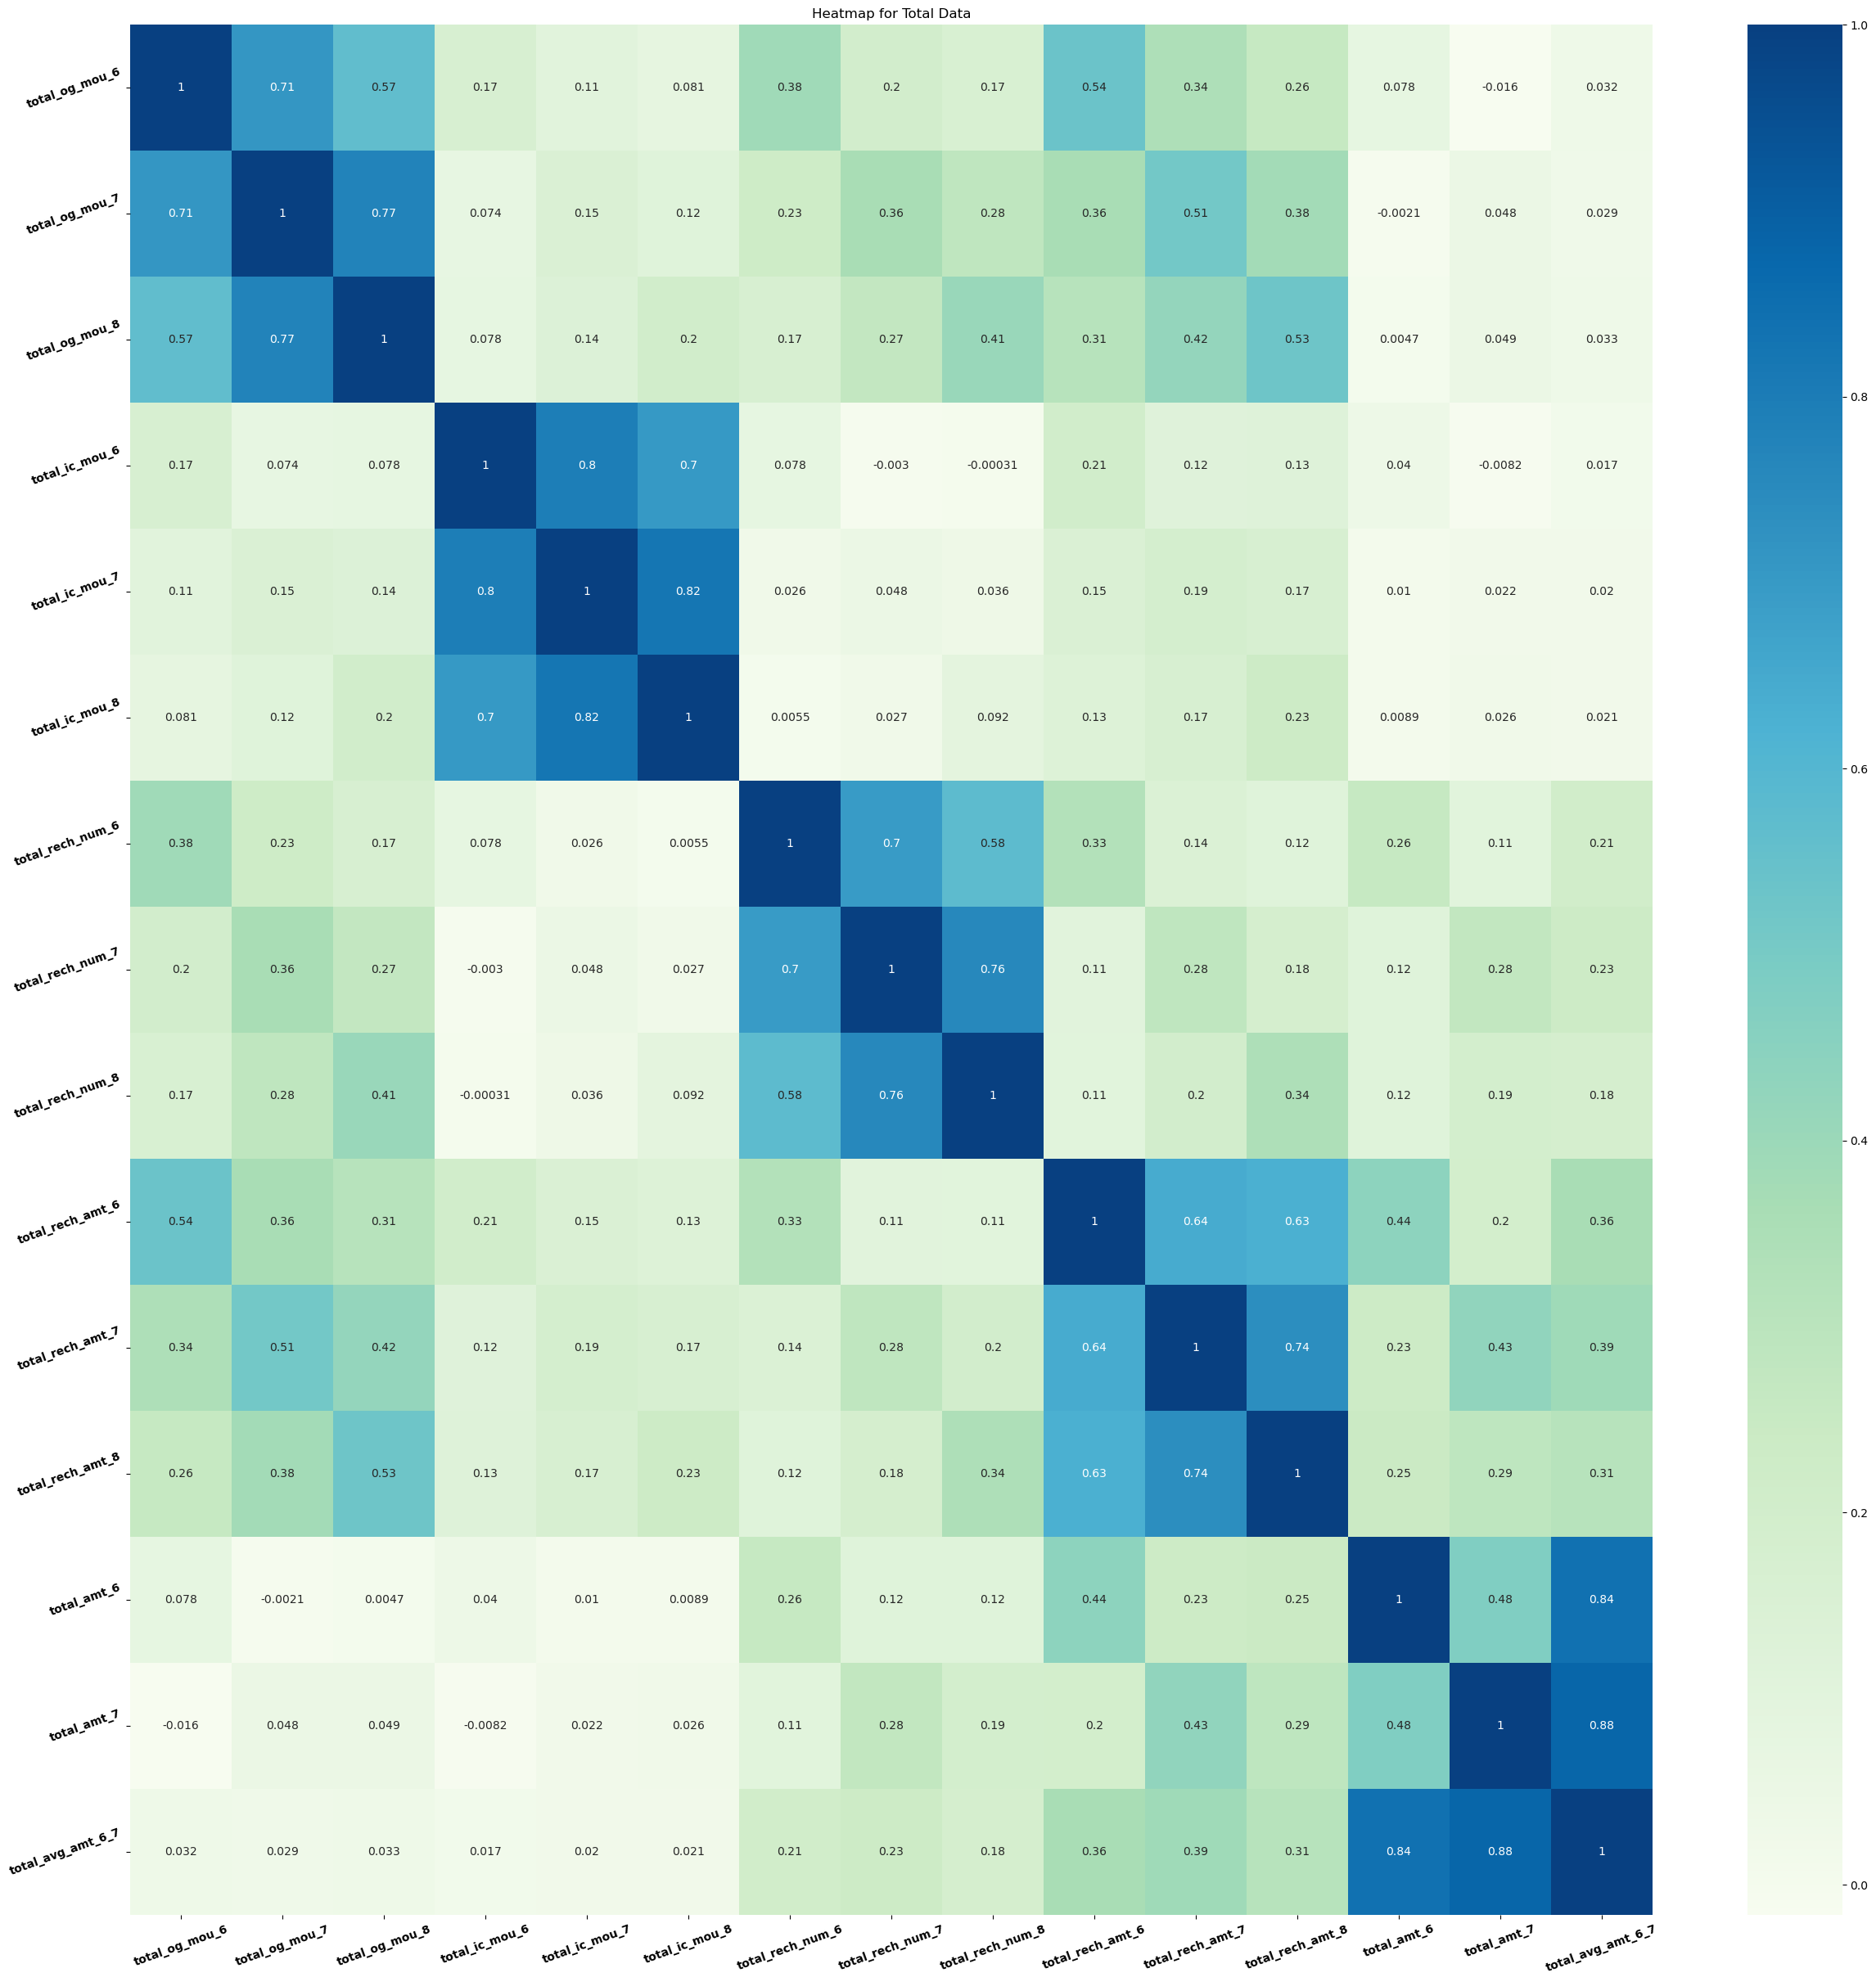

In [67]:
clubbed_cols = {
    'Amount Data': amount_data,
    '2G Data': data_2g,
    '3G Data': data_3g,
    'Incoming Call Minutes (IC MOU)': ic_mou_data,
    'Network Minutes (Net MOU)': net_mou_data,
    'Outgoing Call Minutes (OG MOU)': og_mou_data,
    'Recharge Data': rech_data,
    'Total Data': total_data
}

for name, clubbed_col in clubbed_cols.items():
    print(f'Analyzing correlation in {name}\n')
    plt.figure(figsize=(30,30)) # Adjust the size of the heatmap
    plt.title(f'Heatmap for {name}')
    sns.heatmap(clubbed_col.corr(), annot=True, cmap='GnBu')  # Correct the colormap spelling
    plt.xticks(rotation=20, fontweight='bold')
    plt.yticks(rotation=20, fontweight='bold')
    plt.show()

Here are the top 10 most important points from the inference based on the correlation matrix and heatmap:

    1. High Correlation Between Total Recharge Amounts in Months 7 and 8 (74%):
    Customers who recharge higher amounts in both months tend to exhibit consistent behavior and are less likely to churn. This is a strong indicator of customer retention.

    2. Strong Correlation Between Maximum Recharge and Last Day’s Recharge in Month 8 (68%):
    Users who make large recharges near the end of the month also tend to have higher recharge amounts. This behavior might indicate engagement and lower churn risk.

    3.Consistent Data Usage in 2G and 3G Across Months 7 and 8:
    Strong correlations between recharge amounts for 2G and 3G data in consecutive months indicate consistent behavior, which can be a useful indicator for churn prediction.
    
    4. High Correlation Between Incoming and Outgoing Call Minutes in Months 7 and 8:
    With 82% correlation for incoming minutes and 77% for outgoing minutes, heavy users are less likely to churn. Their high and consistent usage makes them valuable customers.

    5. Correlation Between Total Incoming Call Minutes and Local Call Minutes:
    A strong relationship exists between total incoming and local incoming calls in months 6, 7, and 8. This suggests that consistent call patterns, especially high local call volume, may indicate customer retention.

    6. On-Net and Off-Net Call Minutes Correlation in Months 7 and 8:
    There is a strong correlation between on-net and off-net call minutes in these months, indicating that customers who engage with both types of calls show consistent usage, reducing the likelihood of churn.
    
    7. Strong Correlation in Outgoing Call Minutes (OG_MOU) Across Different Months:
    A high correlation between international outgoing call minutes (ISD) and standard outgoing minutes in months 6, 7, and 8 suggests that users with significant outgoing call volumes tend to be retained.

    8. Recharge Data Indicates Predictive Potential:
    The correlation between the average recharge amount and total recharge amount in months 6 and 7 suggests that customers who regularly recharge significant amounts tend to follow similar behavior in subsequent months, lowering churn risk.

    9. Recharge Patterns in Month 8 Are Strong Predictors of Churn:
    A 76% correlation between total recharge amounts in months 7 and 8 reinforces that recharge behavior in the most recent month is highly predictive of customer retention or churn.

    10. Limited Correlation Between On-Net and Off-Net Usage Minutes:
    While individual on-net and off-net minutes do not exhibit a significant correlation, the strong correlation across months suggests that customers who engage with one service (on-net or off-net) are likely to use the other in the same period.

In [72]:
# Reviewing train and test data set
# Train set
print('Reviewing train data set\n')
type_null_checker(final_df)

# Test set
print('\n------------------\nReviewing train data set\n')
type_null_checker(final_test_df)

Reviewing train data set

Number of "object" columns/features: 0
Number of "int64" columns/features: 25
Number of "float64" columns/features: 117
No columns with null values

------------------
Reviewing train data set

Number of "object" columns/features: 0
Number of "int64" columns/features: 26
Number of "float64" columns/features: 117
No columns with null values


In [73]:
final_df.shape, final_test_df.shape

((20998, 149), (30000, 149))

#### Dummy Variable Creation (One Hot Encoding) - Training Set

In [82]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [84]:
final_df = pd.concat([final_df, dummy_df], axis=1)

In [85]:
# Dropping the redundant categorical cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [86]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20998 entries, 0 to 20997
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(117), int32(12), int64(25)
memory usage: 23.7 MB


#### Dummy Variable Creation (One Hot Encoding) - Test Set

In [88]:
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_test_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

final_test_df = pd.concat([final_test_df, dummy_unseen_df], axis=1)

In [89]:
# Dropping the redundant categorical columns
final_test_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [90]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(117), int32(12), int64(26)
memory usage: 34.1 MB


#### Outlier Treatment

In [92]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
final_df.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean     267.170793    272.100831    240.685694    382.262764    383.247937   
std      466.085572    486.515207    465.230750    480.518888    490.939567   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.440000     17.940000     13.815000     79.540000     75.790000   
50%       90.235000     87.830000     72.685000    234.680000    228.800000   
75%      292.127500    290.620000    245.405000    495.255000    498.790000   
90%      766.325000    788.211000    672.592000    912.390000    922.828000   
95%     1147.427500   1194.174500   1086.979500   1265.446000   1274.301500   
99%     2164.456000   2239.353000   2153.499100   2338.036700   2394.084300   
max     7376.710000   8157.780000  10752.560000   8362.360000   7043.980000   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  20998.000000   20998.000000   20998.000000   20998.000000   
mean     344.876263      16.405599      13.038984      12.474249   
std      476.342812      77.640327      77.874475      72.898547   
min        0.000000       0.000000       0.000000       0.000000   
25%       58.000000       0.000000       0.000000       0.000000   
50%      198.600000       0.000000       0.000000       0.000000   
75%      444.155500       0.000000       0.000000       0.000000   
90%      841.962000      28.202000      14.731000      15.916000   
95%     1172.576500      86.367500      56.947500      56.103500   
99%     2178.008900     335.603500     283.862000     276.136000   
max    14007.340000    2613.310000    3813.290000    4169.810000   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   20998.000000   20998.000000   20998.000000      20998.000000   
mean       27.934132      20.689147      19.923240         85.038230   
std       120.392034      96.604061     104.723255        229.249861   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          5.080000   
50%         0.000000       0.000000       0.000000         25.860000   
75%         0.000000       0.000000       0.000000         81.037500   
90%        52.940000      31.866000      31.440000        186.717000   
95%       154.087500     110.460000      98.946500        318.870500   
99%       546.030900     441.822600     400.673900       1011.725300   
max      3775.110000    2812.040000    5337.040000       6431.330000   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean          86.380968         79.419213        164.867647        163.146327   
std          242.639811        231.911346        248.023770        234.435951   
min            0.000000          0.000000          0.000000          0.000000   
25%            5.190000          3.810000         21.095000         22.330000   
50%           25.840000         22.980000         80.780000         81.785000   
75%           81.840000         75.952500        208.037500        207.112500   
90%          189.975000        178.291000        420.716000        418.840000   
95%          322.768500        298.859500        606.767500        596.846500   
99%         1018.316600        914.494800       1122.801300       1102.060000   
max         7400.660000      10752.560000       4696.830000       4557.140000   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean         153.627135          6.344930          6.421098          6.014542   
std          227.591636         20.192934         20.469991         19.013694   
min            0.000000          0.000000          0.000000          0.000000   

In [98]:
numerical_cols = list(final_df.select_dtypes(exclude='category'))
numerical_cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

<pre>
We will now leverage the previously created 'outlier_handling' function to treat outliers and adjust skewness in the dataset and to improve data robustness and analysis accuracy.

In [101]:
# Handle outliers of numerical columns in the training set
final_df[numerical_cols] = final_df[numerical_cols].apply(outlier_handling)

In [102]:
# Inspecting the numerical columns in the training set after applying the custom outlier function
final_df.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean       4.211139      4.187525      3.998177      5.094078      5.069483   
std        2.016294      2.044529      2.066726      1.674873      1.700992   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.017494      2.941276      2.695640      4.388754      4.341074   
50%        4.513439      4.486724      4.299799      5.462475      5.437209   
75%        5.680608      5.675452      5.506977      6.207090      6.214188   
90%        6.642910      6.671034      6.512625      6.817163      6.828526   
95%        7.046149      7.086047      6.992078      7.143970      7.150938   
99%        7.680386      7.714389      7.675314      7.757494      7.781174   
max        8.906219      9.006850      9.282992      9.031616      8.860071   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  20998.000000   20998.000000   20998.000000   20998.000000   
mean       4.867771       0.714730       0.566267       0.595661   
std        1.803701       1.516128       1.366637       1.367898   
min        0.000000       0.000000       0.000000       0.000000   
25%        4.077537       0.000000       0.000000       0.000000   
50%        5.296315       0.000000       0.000000       0.000000   
75%        6.098424       0.000000       0.000000       0.000000   
90%        6.736922       3.374237       2.755631       2.828260   
95%        7.067811       4.470123       4.059537       4.044865   
99%        7.686625       5.818906       5.652004       5.624508   
max        9.547408       7.868755       8.246510       8.335866   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   20998.000000   20998.000000   20998.000000      20998.000000   
mean        0.835726       0.677053       0.699900          3.073974   
std         1.728676       1.572577       1.561096          1.797019   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.805005   
50%         0.000000       0.000000       0.000000          3.290638   
75%         0.000000       0.000000       0.000000          4.407176   
90%         3.987872       3.492439       3.479392          5.234935   
95%         5.043989       4.713666       4.604635          5.767916   
99%         6.304505       6.093169       5.995640          6.920400   
max         8.236450       7.942021       8.582614          8.769092   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean           3.083276          2.955919          4.052589          4.069228   
std            1.795294          1.832200          1.786656          1.772156   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.822935          1.570697          3.095351          3.149740   
50%            3.289893          3.177220          4.404033          4.416247   
75%            4.416911          4.343188          5.342514          5.338079   
90%            5.252143          5.189010          6.044332          6.039874   
95%            5.780029          5.703314          6.409792          6.393334   
99%            6.926888          6.819465          7.024472          7.005843   
max            8.909460          9.282992          8.454856          8.424670   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean           3.914083          0.931890          0.940227          0.910239   
std            1.871320          1.224449          1.227160          1.208081   
min            0.000000          0.000000          0.000000          0.000000   

In [103]:
# Handle outliers in the test set now
final_test_df[numerical_cols] = final_test_df[numerical_cols].apply(outlier_handling)

In [105]:
# Inspecting the numerical columns in the test set after applying the custom outlier function
final_test_df.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       3.455662      3.399474      3.378267      4.370298      4.322030   
std        1.920246      1.947314      1.946923      1.640813      1.665584   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.163093      2.059239      2.033070      3.599775      3.514824   
50%        3.633895      3.548640      3.540089      4.616011      4.552297   
75%        4.848802      4.825109      4.816605      5.502207      5.462984   
90%        5.875610      5.865638      5.844396      6.167812      6.173644   
95%        6.432364      6.435466      6.414786      6.575421      6.609280   
99%        7.232457      7.293730      7.295839      7.326309      7.341630   
max        8.845829      8.910857      8.813556      8.848432      9.176590   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  30000.000000   30000.000000   30000.000000   30000.000000   
mean       4.293024       0.573719       0.434661       0.448419   
std        1.681242       1.293450       1.124307       1.149469   
min        0.000000       0.000000       0.000000       0.000000   
25%        3.480932       0.000000       0.000000       0.000000   
50%        4.548917       0.000000       0.000000       0.000000   
75%        5.454723       0.000000       0.000000       0.000000   
90%        6.175986       2.811088       2.136767       2.236445   
95%        6.578942       3.724247       3.162581       3.262414   
99%        7.322517       5.383877       5.045232       5.110086   
max        9.514056       9.527002       9.640306       9.480090   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   30000.000000   30000.000000   30000.000000      30000.000000   
mean        0.672716       0.517749       0.513343          2.485723   
std         1.457952       1.289352       1.287077          1.716273   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.032293   
50%         0.000000       0.000000       0.000000          2.593761   
75%         0.000000       0.000000       0.000000          3.778720   
90%         3.360811       2.794289       2.751301          4.640228   
95%         4.270851       3.811783       3.754913          5.164534   
99%         5.612934       5.372013       5.475904          6.310445   
max         7.680841       7.538953       7.959105          8.679232   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      30000.000000      30000.000000      30000.000000      30000.000000   
mean           2.460935          2.457419          3.445514          3.433818   
std            1.714281          1.708467          1.751553          1.746080   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.978326          0.966984          2.416583          2.404690   
50%            2.561868          2.552565          3.760968          3.750445   
75%            3.743368          3.737551          4.739963          4.708719   
90%            4.626344          4.631929          5.457085          5.427550   
95%            5.175081          5.169128          5.848980          5.846940   
99%            6.311273          6.269689          6.607883          6.617005   
max            8.876853          8.813556          8.461837          8.402397   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      30000.000000      30000.000000      30000.000000      30000.000000   
mean           3.418506          0.684468          0.690640          0.682827   
std            1.750461          1.046443          1.051698          1.042433   
min            0.000000          0.000000          0.000000          0.000000   

# Section 3: Model Building and Evaluation

In [108]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'
X = final_df.drop(['churn_probability'], axis=1)

y = final_df['churn_probability']

In [110]:
X.shape, y.shape

((20998, 154), (20998,))

In [111]:
X.head(3)

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     3.103689     1.763017     1.964311      4.060271      3.666378   
1     2.436241     3.257712     5.275202      5.762397      5.837118   
2     6.757548     5.923480     0.636577      5.685143      6.111711   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      2.363680       4.000766            0.0            0.0       2.817204   
1      5.288721       0.000000            0.0            0.0       0.000000   
2      5.960773       0.000000            0.0            0.0       0.000000   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0          2.412336          1.763017   
1            0.0            0.0          2.436241          3.257712   
2            0.0            0.0          6.757548          5.923480   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0          1.964311          3.630721          3.038792          1.724551   
1          5.275202          5.751810          5.804773          5.230467   
2          0.636577          4.391853          6.053570          5.937563   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0          2.564180          0.802002          1.793425               0.0   
1          1.449269          2.477378          1.781709               0.0   
2          2.532108          3.274500          2.290513               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0          2.384165               0.0      4.092843      3.293612   
1          0.000000               0.0      5.794415      5.907512   
2          0.000000               0.0      6.858470      6.713904   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0      2.818995               0.0               0.0               0.0   
1      5.956511               0.0               0.0               0.0   
2      5.963039               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          1.677097               0.0               0.0               0.0   
1          0.000000               0.0               0.0               0.0   
2          5.313600               0.0               0.0               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0           0.00000      1.677097           0.0   
1               0.0           1.98238      0.000000           0.0   
2               0.0           0.00000      5.313600           0.0   

   std_og_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  \
0       0.00000           0.0           0.0           0.0      0.000000   
1       1.98238           0.0           0.0           0.0      0.076961   
2       0.00000           0.0           0.0           0.0      0.000000   

   spl_og_mou_7  spl_og_mou_8  og_others_6  og_others_7  og_others_8  \
0      2.890372       0.00000      0.00000          0.0          0.0   
1      0.000000       0.00000      0.09531          0.0          0.0   
2      0.048790       0.00995      0.00000          0.0          0.0   

   loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
0          1.862529          0.871293          1.297463          2.449279   
1          2.698673          3.053057          5.818390          5.395036   
2          5.456517          4.776009          3.446489          4.826552   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
0          1.673351          3.019937          1.873339          1.532557   
1          6.627036          5.658192          0.000000          1.075002   
2          5.632967          5.009501          3.564166          3.971800   

   loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0          1.965713      3.115292      2.337952      3.377929   


In [112]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: category
Categories (2, int64): [0, 1]

In [113]:
# Performing the train and test split in 80-20 ratio

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [114]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)

X_train Shape: (16798, 154)
y_train Shape: (16798,)
X_val Shape: (4200, 154)
y_val Shape: (4200,)


In [115]:
y_train.value_counts()

churn_probability
0    15400
1     1398
Name: count, dtype: int64

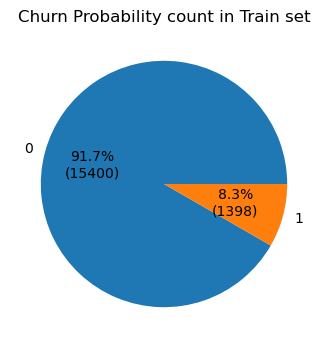

In [123]:
plt.figure(figsize=(4,4))
plt.title('Churn Probability count in Train set')
y_train.value_counts().plot.pie(autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(y_train.value_counts()) / 100))
plt.ylabel('')  # To remove the default ylabel
plt.show()

#### Handling Data Imbalance using Synthetic Minority Over-sampling Technique (SMOTE):
        - SMOTE randomly selects one of the k nearest neighbors and generates a new, synthetic sample by interpolating between the original instance and its neighbor. This interpolation involves choosing a point along the line segment that connects the two instances in feature space.
        - Improves Model Performance: By creating synthetic data, SMOTE helps balance the class distribution, making the model more sensitive to the minority class and reducing bias toward the majority class.
        - Prevents Overfitting: Unlike simple oversampling, which duplicates existing instances, SMOTE generates new, unique instances, which reduces the risk of overfitting the model to repeated data points.

In [124]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [126]:
X_train_smote.shape, y_train_smote.shape

((30800, 154), (30800,))

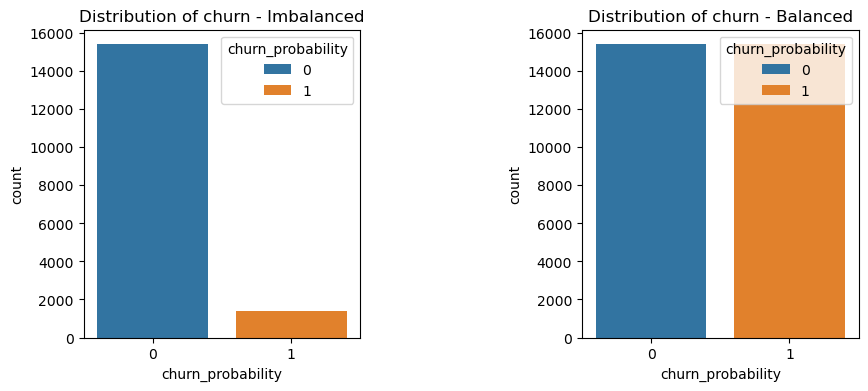

In [131]:
# Reviewing the distribution on our target variable 'y_train' before and after SMOTE
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Distribution of churn - Imbalanced')
sns.countplot(x=y_train, hue=y_train)

plt.subplot(1,2,2)
plt.title('Distribution of churn - Balanced')
sns.countplot(x=y_train_smote, hue=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()

<pre>
Addressed the data imbalance issue

#### Feature scaling using StandardScaler - Training Set

In [134]:
# instantiating Standard scaler 
scaler = StandardScaler()

# fitting the scaler
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns=X_train_smote.columns, index=X_train_smote.index)

# Transforming the validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns, index = X_val.index)

In [135]:
X_train_scaled.head(3)

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     0.149097     0.096313     0.612506     -0.131917     -0.127232   
1    -0.011491     0.097480     0.221881     -0.168733     -0.384974   
2     1.347333     1.161160     1.273533     -0.123081     -0.561949   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      0.241259       2.442332      -0.530507       2.266093       2.179343   
1      0.112299       0.953739      -0.530507       1.403829       1.516741   
2     -0.429040      -0.527310      -0.530507      -0.665387      -0.547857   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0      -0.570207       2.091586          0.273359          0.528093   
1      -0.570207       0.612709          0.120881          0.772326   
2      -0.570207      -0.710456          0.854252          0.839269   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0          0.444370         -0.221221          0.327531          0.122703   
1          0.746182          0.251781          0.058031          0.397469   
2          0.670896         -0.308468         -0.227502         -0.232781   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0         -0.523643          0.030778         -0.701993          2.646044   
1          2.131453          0.957430          0.526305         -0.523327   
2         -0.723977         -0.708058         -0.701993         -0.523327   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0         -0.431035         -0.561881     -0.095625      0.327008   
1         -0.553536          2.426370      0.265493      0.314293   
2         -0.553536         -0.561881      0.213057      0.235416   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0      0.199779         -0.004908          0.369367          0.763584   
1      0.473692          0.278304         -0.011329          0.247915   
2      0.165715          1.564215          1.436989          1.666454   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          0.050386          0.250157          0.324023         -0.357822   
1         -0.288976          0.091735          0.239823         -0.357822   
2          0.545877          0.100393          0.227695         -0.357822   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0          -0.35426         -0.361352     -0.081114      0.188770   
1          -0.35426          3.410395     -0.071045     -0.045677   
2          -0.35426         -0.361352      1.099370      0.951420   

   std_og_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  \
0      0.459009     -0.272011     -0.264311     -0.292629      1.101213   
1      0.244684     -0.272011     -0.264311      0.759191     -0.914386   
2      1.146621     -0.272011     -0.264311     -0.292629     -0.110887   

   spl_og_mou_7  spl_og_mou_8  og_others_6  og_others_7  og_others_8  \
0     -0.873126     -0.905436    -0.558256     -0.06942    -0.069571   
1     -0.952642      1.555758    -0.558256     -0.06942    -0.069571   
2     -0.952642     -0.905436    -0.558256     -0.06942    -0.069571   

   loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
0          0.458698          0.046129          0.421804          0.247695   
1          0.024747          0.151807          0.514083         -0.196068   
2          0.916711          0.642729          0.652673          0.548223   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
0          0.560099          0.145854          1.188196          1.764876   
1         -0.286092          0.201365          1.261346          0.530525   
2          0.175810         -0.393634         -0.752788         -0.895155   

   loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0          1.454569      0.292823      0.514741      0.315160   


In [137]:
X_val_scaled.head(3)

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
3837     -0.723901    -1.063082    -0.497881     -0.477713     -0.553699   
11055    -0.475413    -2.030273    -1.781341      0.611707     -1.772745   
12221    -2.144474    -1.391983     0.495678     -2.785621     -0.880088   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
3837      -0.596502       -0.52731      -0.530507      -0.665387   
11055     -2.389265       -0.52731      -0.530507      -0.665387   
12221      0.437747       -0.52731      -0.097707      -0.665387   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
3837       -0.547857      -0.570207      -0.710456         -0.021440   
11055      -0.489433      -0.570207      -0.710456         -1.177990   
12221      -0.284733      -0.570207      -0.710456         -1.705461   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
3837          -0.460323          0.110771          0.218220          0.142564   
11055         -1.598152         -1.366571         -1.605485         -2.051296   
12221         -1.432218          0.190970         -2.197663         -1.560477   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
3837           0.032738         -0.723977         -0.708058         -0.701993   
11055         -1.664508         -0.723977         -0.708058         -0.701993   
12221         -0.002149         -0.723977         -0.708058         -0.701993   

       loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
3837          -0.523327         -0.553536         -0.561881      0.095236   
11055         -0.523327         -0.553536         -0.561881     -1.552446   
12221         -0.523327         -0.553536          2.403270     -2.352860   

       loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
3837      -0.023697      0.035381         -1.102510         -1.041848   
11055     -2.181437     -1.740851          0.165348         -1.041848   
12221     -1.643610      0.038762         -1.102510         -0.575495   

       std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
3837          -0.915448         -1.353028         -1.264916         -1.091729   
11055         -0.915448          1.117278         -1.264916         -1.091729   
12221          0.970752         -1.353028          0.113099          1.002671   

       std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  \
3837          -0.357822          -0.35426         -0.361352     -1.513914   
11055         -0.357822          -0.35426         -0.361352      0.760308   
12221         -0.357822          -0.35426          2.006538     -1.513914   

       std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  \
3837      -1.411992     -1.207651     -0.272011     -0.264311     -0.292629   
11055     -1.411992     -1.207651     -0.272011     -0.264311     -0.292629   
12221     -0.136897      0.851497     -0.272011     -0.264311     -0.292629   

       spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  og_others_7  \
3837       1.053494      0.381702     -0.905436    -0.558256     -0.06942   
11055      1.538966      0.695460     -0.905436    -0.344888     -0.06942   
12221     -0.914386     -0.952642      1.826622    -0.558256     -0.06942   

       og_others_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
3837     -0.069571         -0.528017         -0.630131         -0.290168   
11055    -0.069571         -1.443315         -1.797907         -1.503523   
12221    -0.069571         -1.872795         -0.936458          0.500096   

       loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  \
3837          -1.894699         -1.557462         -0.780535         -0.929792   
11055         -1.716850         -2.375158         -1.877587         -0.929792   
12221         -2.578031         -1.291162         -0.008022         -0.929792   

In [140]:
final_test_df.set_index('id', inplace=True)
final_test_df

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                         
69999     3.489819     3.055415     3.182627      4.113493      3.501344   
70000     4.337421     3.742657     3.036874      6.164030      6.434290   
70001     2.144761     2.181547     2.240710      2.889260      3.846097   
70002     1.842136     1.150572     0.000000      3.714547      5.327925   
70003     6.113527     6.413508     6.553477      4.126166      3.212455   
...            ...          ...          ...           ...           ...   
99994     5.785240     5.525493     5.657424      5.254156      5.118832   
99995     5.578937     6.148981     6.478909      4.696198      4.829193   
99996     2.491551     2.765690     3.041661      3.643882      2.875822   
99997     4.818183     3.936325     3.312730      7.525688      6.993777   
99998     3.370394     3.524300     4.209309      4.689327      5.491125   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                 
69999      3.578786       0.000000       0.000000       0.000000   
70000      5.981263       0.000000       0.000000       0.000000   
70001      3.829511       3.170106       4.648038       3.298795   
70002      3.219276       0.000000       0.000000       0.000000   
70003      4.319619       0.000000       0.000000       0.000000   
...             ...            ...            ...            ...   
99994      5.406992       4.485936       2.758743       0.000000   
99995      5.251016       1.481605       0.000000       0.000000   
99996      3.834710       0.000000       0.000000       3.242202   
99997      5.727369       0.000000       3.120601       0.000000   
99998      5.807061       4.909267       4.231058       4.961305   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                     
69999       0.000000       0.000000       0.000000          3.253470   
70000       0.000000       0.000000       0.000000          4.337421   
70001       3.239854       4.001498       4.015301          0.000000   
70002       0.000000       0.000000       0.000000          1.842136   
70003       0.000000       0.000000       0.000000          0.371564   
...              ...            ...            ...               ...   
99994       4.731186       2.247072       0.000000          5.375232   
99995       2.228939       0.000000       0.000000          1.805005   
99996       0.000000       0.000000       2.808197          2.491551   
99997       0.000000       3.330059       0.000000          0.722706   
99998       4.873899       4.415703       5.197613          0.000000   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                              
69999          3.055415          3.093766          2.951258          2.475698   
70000          3.742657          3.036874          6.162493          6.395395   
70001          0.000000          0.000000          0.000000          0.000000   
70002          0.000000          0.000000          1.371181          4.601263   
70003          0.576613          2.744704          1.220830          1.297463   
...                 ...               ...               ...               ...   
99994          5.459415          5.628484          5.092277          5.070098   
99995          2.908539          2.650421          3.154444          3.544720   
99996          2.036012          2.149434          3.175133          2.223542   
99997          1.759581          0.000000          4.080246          4.402809   
99998          1.806648          2.912894          0.000000          2.571849   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                           

### Model 1. Logistic Regression with Recursive Feature Elimination (RFE)

In [320]:
%%time
# Select top 20 features using RFE

logreg = LogisticRegression(max_iter=1000, tol=0.0001, solver='sag')
# max_iter=1000 allows the model to take up to 1,000 steps (iterations) to adjust the parameters.
# tol=0.0001 to get a more precise model
# solver='sag': 'sag' is (Stochastic Average Gradient) is efficient for large datasets 
# can use penalty='l2', C=1.0 handle feature selection indirectly through penalizing less important features
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

CPU times: total: 1min 21s
Wall time: 18min 31s


In [321]:
# Listing all the features with their priority order from the Training set

list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 59),
 ('onnet_mou_7', False, 26),
 ('onnet_mou_8', False, 25),
 ('offnet_mou_6', False, 88),
 ('offnet_mou_7', False, 16),
 ('offnet_mou_8', False, 13),
 ('roam_ic_mou_6', False, 74),
 ('roam_ic_mou_7', False, 34),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', False, 73),
 ('roam_og_mou_7', False, 28),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 90),
 ('loc_og_t2t_mou_7', False, 60),
 ('loc_og_t2t_mou_8', False, 65),
 ('loc_og_t2m_mou_6', False, 22),
 ('loc_og_t2m_mou_7', False, 36),
 ('loc_og_t2m_mou_8', False, 23),
 ('loc_og_t2f_mou_6', False, 118),
 ('loc_og_t2f_mou_7', False, 38),
 ('loc_og_t2f_mou_8', False, 37),
 ('loc_og_t2c_mou_6', False, 80),
 ('loc_og_t2c_mou_7', False, 128),
 ('loc_og_t2c_mou_8', False, 109),
 ('loc_og_mou_6', False, 21),
 ('loc_og_mou_7', False, 15),
 ('loc_og_mou_8', False, 14),
 ('std_og_t2t_mou_6', False, 32),
 ('std_og_t2t_mou_7', False, 27),
 ('std_og_t2t_mou_8', False, 24),
 ('std_og_t2m_mou_6', False, 33),
 ('s

In [322]:
# Selecting features picked using RFE

selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8',
       'night_pck_user_8_0.0'],
      dtype='object')

In [323]:
X_train_scaled_final = X_train_scaled[selected_features]
X_train_scaled_final.head()

roam_ic_mou_8  roam_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
0       2.266093       2.091586          0.046129          0.421804   
1       1.403829       0.612709          0.151807          0.514083   
2      -0.665387      -0.710456          0.642729          0.652673   
3      -0.665387      -0.710456          0.096964          0.351824   
4      -0.665387      -0.710456          0.317121         -0.194048   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
0          0.560099          0.145854      0.514741      0.315160   
1         -0.286092          0.201365     -0.159358      0.268156   
2          0.175810         -0.393634      0.237537      0.046365   
3          0.683399          0.753291      0.510334      0.757683   
4         -0.238845         -0.080099     -0.130234     -0.139595   

   spl_ic_mou_8  total_ic_mou_8  total_rech_num_7  total_rech_num_8  \
0     -0.266206        0.571604         -1.434322         -0.619858   
1      1.077847       -1.395256         -1.887514         -0.334571   
2     -0.266206        0.342433         -0.156845          0.266323   
3     -0.266206        0.837603          0.539185          0.551610   
4     -0.266206        0.117396          0.749540          1.437791   

   total_rech_amt_6  total_rech_amt_8  max_rech_amt_6  max_rech_amt_8  \
0          0.797311          0.423521        2.113502        0.941732   
1         -0.317314          0.907096        0.149022        1.543769   
2         -2.115286         -0.327246       -1.048391        0.007047   
3          0.534151          0.865619        0.564645        0.791004   
4          0.435124          0.877542        0.004934        0.662382   

   last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  night_pck_user_8_0.0  
0            1.480695         1.828966         1.558462              1.363391  
1           -1.039975        -0.735593        -0.595224             -0.759323  
2           -1.039975        -0.735593        -0.595224             -0.759323  
3            1.335531         1.681275         0.982153              1.363391  
4            1.211658         0.267637         1.395204             -0.759323

In [324]:
# Fitting the model
logreg.fit(X_train_scaled_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag')

In [326]:
# Predicting the values
y_train_smote_pred = logreg.predict(X_train_scaled_final)

In [327]:
# Calculate metrics on the training set
classification_metrics_calculator(y_train_smote, y_train_smote_pred)

Confusion Matrix

 [[13533  1867]
 [ 2541 12859]]


Metric   Value
0             Accuracy  0.8569
1          Sensitivity  0.8350
2          Specificity  0.8788
3            Precision  0.8732
4  False Positive Rate  0.1212
5   True Positive Rate  0.8350

In [328]:
# Using RFE features on the 20% test subset of the Training data
X_val_scaled_final = X_val_scaled[selected_features]
X_val_scaled_final.head()

roam_ic_mou_8  roam_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
3837       -0.665387      -0.710456         -0.630131         -0.290168   
11055      -0.665387      -0.710456         -1.797907         -1.503523   
12221      -0.665387      -0.710456         -0.936458          0.500096   
17179       0.507003       0.310656         -1.797907         -1.503523   
16047      -0.665387      -0.710456          1.009888          1.293739   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
3837          -1.557462         -0.780535     -1.260499     -0.619060   
11055         -2.375158         -1.877587     -2.594398     -1.984767   
12221         -1.291162         -0.008022     -1.288229      0.116259   
17179         -2.375158         -1.877587     -2.594398     -1.984767   
16047          0.136627          0.558739      0.498659      0.815106   

       spl_ic_mou_8  total_ic_mou_8  total_rech_num_7  total_rech_num_8  \
3837      -0.266206       -0.300154         -1.082799         -0.101475   
11055      2.474225       -1.317514         -1.434322         -0.619858   
12221      6.933130        0.329095          0.159277          1.437791   
17179     -0.266206       -1.395256          0.159277         -0.101475   
16047     -0.266206        0.859190         -1.887514         -0.987657   

       total_rech_amt_6  total_rech_amt_8  max_rech_amt_6  max_rech_amt_8  \
3837           0.204074          0.547510        0.794832        0.902878   
11055          0.035264          0.561889        0.794832        0.902878   
12221         -5.086412          0.669800       -4.510459        0.156583   
17179          0.347429         -0.539241        0.004934       -0.256881   
16047          0.431105         -1.678770        1.078205       -1.675565   

       last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  \
3837            -1.039975         1.790895        -0.595224   
11055           -1.039975         1.790895        -0.595224   
12221            0.724532        -0.735593        -0.595224   
17179           -1.039975        -0.735593        -0.595224   
16047           -1.039975        -0.735593        -0.595224   

       night_pck_user_8_0.0  
3837               1.363391  
11055              1.363391  
12221             -0.759323  
17179             -0.759323  
16047             -0.759323

In [329]:
# Predicting the response on the 20% subset of training data
y_val_pred = logreg.predict(X_val_scaled_final)

In [330]:
# Evaluating the accuracy of the model
classification_metrics_calculator(y_val, y_val_pred)

Confusion Matrix

 [[3379  484]
 [  76  261]]


Metric   Value
0             Accuracy  0.8667
1          Sensitivity  0.7745
2          Specificity  0.8747
3            Precision  0.3503
4  False Positive Rate  0.1253
5   True Positive Rate  0.7745

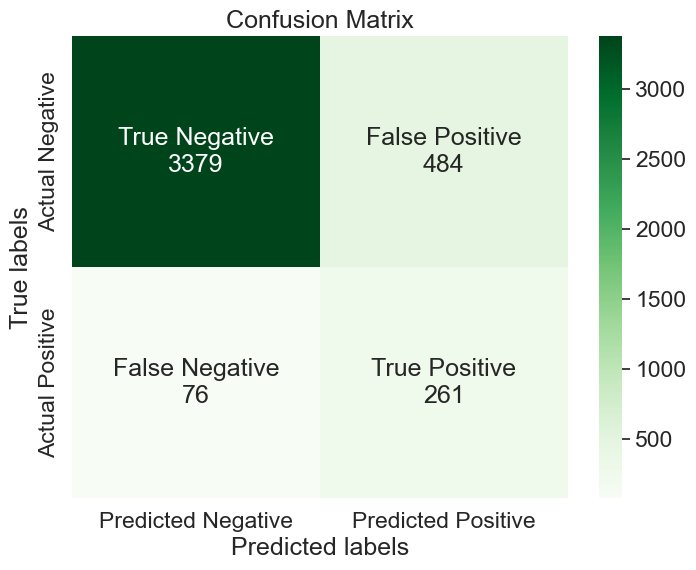

In [331]:
# Plotting the confusion matrix

confusion_mx = confusion_matrix(y_val, y_val_pred) # storing the confusion matrix in a variable
# np.array(confusion_mx).reshape(2,2) # not needed as the o/p of confusion_mx is already a 2x2 array

# Custom labels for the cells of the confusion matrix
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Combine the confusion matrix values and the custom labels into one string for each cell
annot_labels = np.array([[f'{labels[i, j]}\n{confusion_mx[i, j]}' for j in range(2)] for i in range(2)])

# Creating a heatmap
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.heatmap(confusion_mx, annot=annot_labels, cmap='Greens', fmt='', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive']) #fmt='g' specifically means that 
                                                                #the numbers will be displayed as 
                                                                #integers (general number format)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

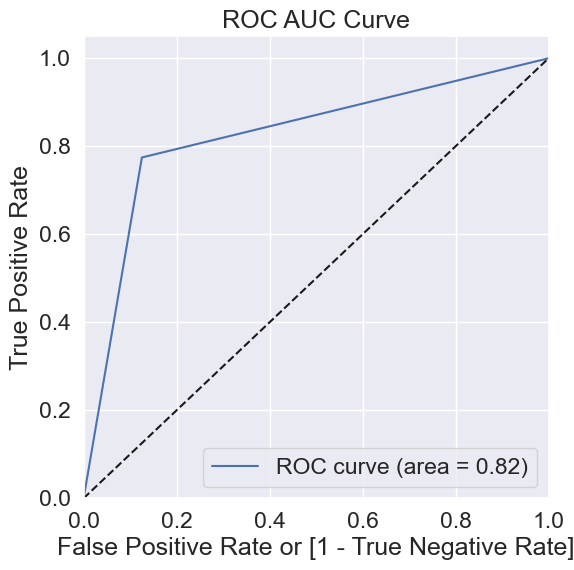

In [332]:
# ROC curve
fpr, tpr, thresholds = plot_roc(y_val, y_val_pred)

<pre>
-----------------------------------------------------------------------

### Model 1.1 Logistic Regression with RFE - 25 features

In [356]:
%%time
# Select top 25 features using RFE

logreg_25 = LogisticRegression(max_iter=1000, tol=0.0001, solver='sag')
rfe_25 = RFE(logreg_25, n_features_to_select=25)
rfe_25 = rfe_25.fit(X_train_scaled, y_train_smote)

CPU times: total: 1min 18s
Wall time: 9min 19s


In [361]:
# Selecting features picked using RFE

selected_features_25 = X_train_scaled.columns[rfe_25.support_]
selected_features_25

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8',
       'vol_2g_mb_6', 'vol_2g_mb_8', 'vol_3g_mb_6', 'total_amt_6',
       'night_pck_user_8_0.0', 'night_pck_user_6_0.0'],
      dtype='object')

In [362]:
X_train_scaled_final_25 = X_train_scaled[selected_features_25]
X_train_scaled_final_25.head()

roam_ic_mou_8  roam_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
0       2.266093       2.091586          0.046129          0.421804   
1       1.403829       0.612709          0.151807          0.514083   
2      -0.665387      -0.710456          0.642729          0.652673   
3      -0.665387      -0.710456          0.096964          0.351824   
4      -0.665387      -0.710456          0.317121         -0.194048   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
0          0.560099          0.145854      0.514741      0.315160   
1         -0.286092          0.201365     -0.159358      0.268156   
2          0.175810         -0.393634      0.237537      0.046365   
3          0.683399          0.753291      0.510334      0.757683   
4         -0.238845         -0.080099     -0.130234     -0.139595   

   spl_ic_mou_8  total_ic_mou_8  total_rech_num_7  total_rech_num_8  \
0     -0.266206        0.571604         -1.434322         -0.619858   
1      1.077847       -1.395256         -1.887514         -0.334571   
2     -0.266206        0.342433         -0.156845          0.266323   
3     -0.266206        0.837603          0.539185          0.551610   
4     -0.266206        0.117396          0.749540          1.437791   

   total_rech_amt_6  total_rech_amt_8  max_rech_amt_6  max_rech_amt_8  \
0          0.797311          0.423521        2.113502        0.941732   
1         -0.317314          0.907096        0.149022        1.543769   
2         -2.115286         -0.327246       -1.048391        0.007047   
3          0.534151          0.865619        0.564645        0.791004   
4          0.435124          0.877542        0.004934        0.662382   

   last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  vol_2g_mb_6  \
0            1.480695         1.828966         1.558462    -0.299683   
1           -1.039975        -0.735593        -0.595224    -0.786753   
2           -1.039975        -0.735593        -0.595224    -0.786753   
3            1.335531         1.681275         0.982153     2.147754   
4            1.211658         0.267637         1.395204     1.490693   

   vol_2g_mb_8  vol_3g_mb_6  total_amt_6  night_pck_user_8_0.0  \
0     0.727420     1.186961     0.599767              1.363391   
1    -0.572525    -0.658600    -0.656989             -0.759323   
2    -0.572525    -0.658600    -2.429514             -0.759323   
3     2.531883    -0.658600     0.339611              1.363391   
4     1.583298    -0.658600     0.261648             -0.759323   

   night_pck_user_6_0.0  
0              1.043735  
1             -0.998620  
2             -0.998620  
3              1.043735  
4             -0.998620

In [363]:
X_train_scaled_final_25.shape

(30800, 25)

In [364]:
# Fitting the model
logreg_25.fit(X_train_scaled_final_25, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag')

In [366]:
# Predicting the values
y_train_smote_pred_25 = logreg_25.predict(X_train_scaled_final_25)

In [367]:
# Calculate metrics on the training set
classification_metrics_calculator(y_train_smote, y_train_smote_pred_25)

Confusion Matrix

 [[13529  1871]
 [ 2383 13017]]


Metric   Value
0             Accuracy  0.8619
1          Sensitivity  0.8453
2          Specificity  0.8785
3            Precision  0.8743
4  False Positive Rate  0.1215
5   True Positive Rate  0.8453

In [368]:
# Using RFE features on the 20% test subset of the Training data
X_val_scaled_final_25 = X_val_scaled[selected_features_25]

# Predicting the response on the 20% subset of training data
y_val_pred_25 = logreg_25.predict(X_val_scaled_final_25)

# Evaluating the accuracy of the model
classification_metrics_calculator(y_val, y_val_pred_25)

Confusion Matrix

 [[3375  488]
 [  75  262]]


Metric   Value
0             Accuracy  0.8660
1          Sensitivity  0.7774
2          Specificity  0.8737
3            Precision  0.3493
4  False Positive Rate  0.1263
5   True Positive Rate  0.7774

### Model 2. Logistic Regression with Hyperparameter Tuning and PCA

In [180]:
pca = PCA()

In [183]:
pca_comp = pca.fit_transform(X_train)
pca_comp

array([[-4.89085664e-01,  2.83715755e+00,  3.62035943e+00, ...,
         1.71853453e-13,  2.54461171e-14, -2.92771558e-14],
       [-6.47600567e+00, -4.59799754e+00, -1.14580321e+00, ...,
        -5.46945262e-14, -6.44861002e-15, -2.40285404e-17],
       [-1.19215656e+01, -4.15668288e+00,  2.45700465e+00, ...,
         8.42400699e-15,  1.71910098e-15,  8.25593788e-16],
       ...,
       [ 3.92520242e+00,  3.86956618e+00, -2.86508448e-01, ...,
         1.17565684e-15, -3.09828382e-16, -1.88913150e-16],
       [ 1.23246908e+01, -8.91562760e-01, -1.74475630e+00, ...,
        -1.34214989e-15,  5.42419341e-16,  3.90148683e-16],
       [ 2.52715271e+01, -4.94131816e+00,  6.79110471e+00, ...,
        -6.24926577e-15,  1.25389133e-15, -3.17212040e-16]])

#### Plotting the first two Principal Component - PC1, PC2

<pre>
The first two principal components PC1 and PC2 captures maximum variance in the dataset (i.e. the most important information). The plot will help visualize how well these two components separate the data, and how much variance is explained by PC1 and PC2.

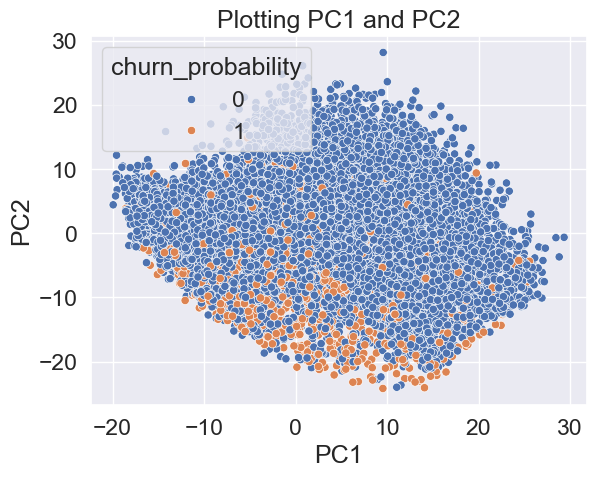

In [185]:
sns.scatterplot(x=pca_comp[:,0], y=pca_comp[:,1], hue=y_train)
plt.title('Plotting PC1 and PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

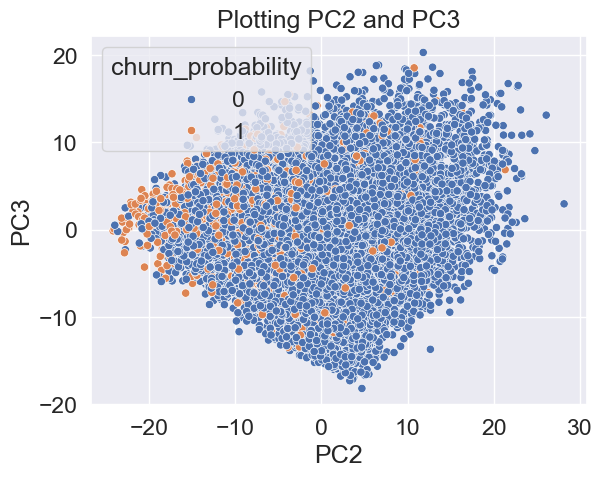

In [186]:
sns.scatterplot(x=pca_comp[:,1], y=pca_comp[:,2], hue=y_train)
plt.title('Plotting PC2 and PC3')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

<pre>
As evident from the above two plots, there is indeed an imbalance in the two response and we should leverage this using SMOTE.

In [196]:
# Displaying the X and y sets
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)

X_train Shape: (16798, 154)
y_train Shape: (16798,)
X_val Shape: (4200, 154)
y_val Shape: (4200,)


In [197]:
# imputer = SimpleImputer()
# Leveraging the KNN imputer instead of the SimpleImputer here
scaler = StandardScaler()
pca = PCA(n_components=20)
smote = SMOTE(random_state=2)
lr = LogisticRegression(max_iter=1000, tol=0.0001, random_state=42)

In [198]:
pipe = make_pipeline(
    smote,
    scaler,
    pca,
    lr
)

<pre>
Regularization:->
By default, Logistic Regression in Scikit-learn applies L2 regularization when you use the C parameter:

    > When you use C without specifying the type of regularization, the L2 regularization (Ridge) is applied by default.
    > L2 regularization adds a penalty based on the sum of the squared coefficients (weights) to shrink them, preventing large coefficients and overfitting.

Solver:->
The solver is the optimization algorithm used to find the best parameters (like coefficients) for the Logistic Regression model. Different solvers use different methods to converge on a solution, and their efficiency depends on the problem size and regularization type.

liblinear:

    Used for smaller datasets.
    Supports both L1 and L2 regularization.
    This is a good choice for binary classification or when there are a relatively small number of samples and features.
    
saga:

    Used for larger datasets.
    Supports both L1 and L2 regularization.
    It's one of the few solvers that can efficiently handle L1 regularization for large datasets and is also useful for multinomial logistic regression.
    
    

In [201]:
# Hyperparameter grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
}

In [202]:
# Instantiate GridSearchCV

lr_grid_search = GridSearchCV(pipe,
                                param_grid,
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=1)

In [349]:
# Fitting the model using GridSearchCV

lr_grid_search.fit(X_train, y_train)

# Fetching the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
print('Best Parameters:', lr_best_params)
lr_best_estimator = lr_grid_search.best_estimator_
print('Best estimator:', lr_best_estimator)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'logisticregression__C': 0.001, 'logisticregression__solver': 'liblinear'}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=2)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=20)),
                ('logisticregression',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=42,
                                    solver='liblinear'))])


In [350]:
# Predicting values on the training set
y_train_pred = lr_grid_search.predict(X_train)

In [351]:
# Predicting on the 20% test set
y_val_pred = lr_grid_search.predict(X_val)

In [352]:
# Evaluating the model on training set
classification_metrics_calculator(y_train, y_train_pred)

Confusion Matrix

 [[13498  1902]
 [  309  1089]]


Metric   Value
0             Accuracy  0.8684
1          Sensitivity  0.7790
2          Specificity  0.8765
3            Precision  0.3641
4  False Positive Rate  0.1235
5   True Positive Rate  0.7790

In [353]:
# Evaluating the model on test set
classification_metrics_calculator(y_val, y_val_pred)

Confusion Matrix

 [[3383  480]
 [  79  258]]


Metric   Value
0             Accuracy  0.8669
1          Sensitivity  0.7656
2          Specificity  0.8757
3            Precision  0.3496
4  False Positive Rate  0.1243
5   True Positive Rate  0.7656

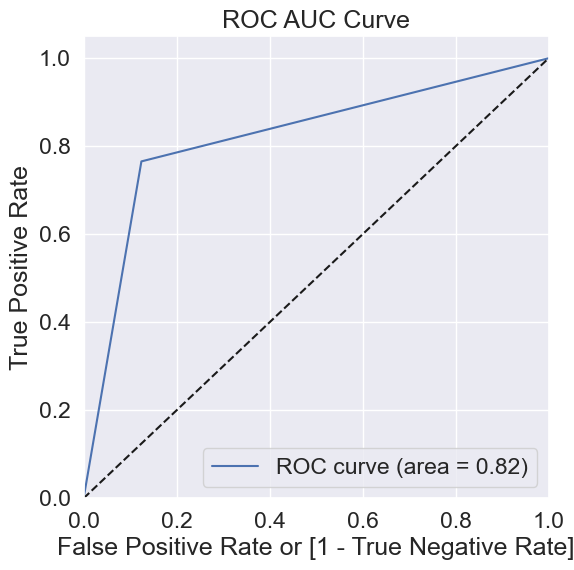

In [354]:
# Plotting ROC curve
fpr, tpr, threshold = plot_roc(y_val, y_val_pred)

### Model 3. Decision Tree with PCA and GridSearchCV

In [247]:
dt = DecisionTreeClassifier(random_state=42)

In [248]:
#imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=26)
smote = SMOTE(random_state=2)

In [249]:
# Create a pipeline
pipe = make_pipeline(
    #imputer,
    smote,
    scaler,
    pca,
    dt
)

In [250]:
# Create the parameter grid based on the results of random search 
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
}

In [251]:
# Instantiate the grid search model
dt_grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, 
                           verbose=1, 
                           scoring = "accuracy")

In [252]:
# Fit the Dt GridSearchCV
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=26)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             scoring='accuracy', verbose=1)

In [253]:
# Get the best parameters and the best score
best_params = dt_grid_search.best_params_
print('Best Parameters:', best_params)
best_score = dt_grid_search.best_score_
print('Best score:', best_score)

# Predict on train set using the best model
y_train_pred = dt_grid_search.predict(X_train)

# Predict on validation set using the best model
y_val_pred = dt_grid_search.predict(X_val)

Best Parameters: {'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__min_samples_leaf': 10}
Best score: 0.8549237301351026


In [254]:
# Metrics on the train set
classification_metrics_calculator(y_train, y_train_pred)

Confusion Matrix

 [[14373  1027]
 [  117  1281]]


Metric   Value
0             Accuracy  0.9319
1          Sensitivity  0.9163
2          Specificity  0.9333
3            Precision  0.5550
4  False Positive Rate  0.0667
5   True Positive Rate  0.9163

In [255]:
# Metrics on the validation set
classification_metrics_calculator(y_val, y_val_pred)

Confusion Matrix

 [[3381  482]
 [ 127  210]]


Metric   Value
0             Accuracy  0.8550
1          Sensitivity  0.6231
2          Specificity  0.8752
3            Precision  0.3035
4  False Positive Rate  0.1248
5   True Positive Rate  0.6231

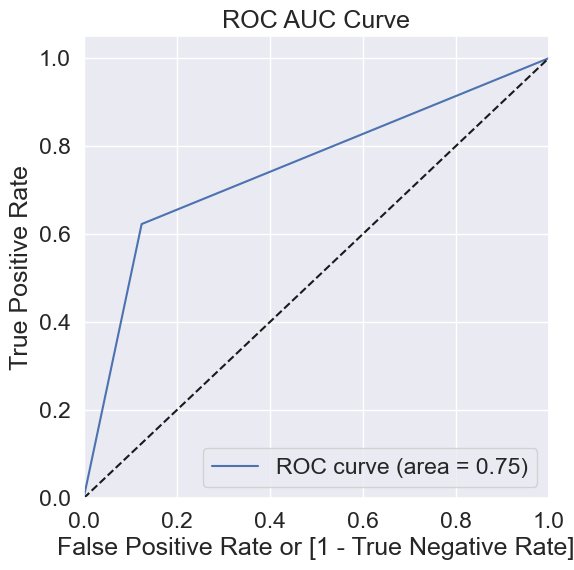

In [256]:
# ROC curve
fpr, tpr, thresholds = plot_roc(y_val, y_val_pred)

### Model 4. Random Forest Classifier with PCA and Hyperparameter Tuning

In [257]:
rf = RandomForestClassifier(random_state=42)

In [258]:
# Creating a pipeline
pipe = make_pipeline(
                    smote,
                    scaler,
                    pca,
                    rf) # using KNN imputed values here already

In [259]:
# Defining the Hyperparameters grid for Random Forest
param_grid = {
    'randomforestclassifier__n_estimators':[100],
    'randomforestclassifier__max_depth':[5, 10],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

In [260]:
rf_grid_search = GridSearchCV(pipe,
                             param_grid,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1,
                             verbose=1)

In [261]:
%%time
# Fit the grid search to the training data
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 4.38 s
Wall time: 1min 4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=26)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100]},
             scoring='accuracy', verbose=1)

In [265]:
# Fetching the best parameters

best_params = rf_grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = rf_grid_search.best_estimator_


# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_val)

Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 100}


In [266]:
# Evaluating train set
classification_metrics_calculator(y_train, y_train_pred)

Confusion Matrix

 [[14349  1051]
 [  118  1280]]


Metric   Value
0             Accuracy  0.9304
1          Sensitivity  0.9156
2          Specificity  0.9318
3            Precision  0.5491
4  False Positive Rate  0.0682
5   True Positive Rate  0.9156

In [267]:
# Evaluating test set
classification_metrics_calculator(y_val, y_val_pred)

Confusion Matrix

 [[3381  482]
 [ 127  210]]


Metric   Value
0             Accuracy  0.8550
1          Sensitivity  0.6231
2          Specificity  0.8752
3            Precision  0.3035
4  False Positive Rate  0.1248
5   True Positive Rate  0.6231

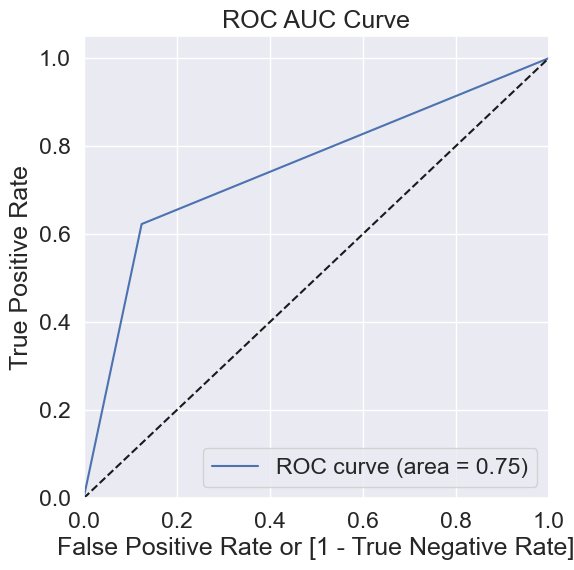

In [269]:
# ROC curve
fpr, tpr, thresholds = plot_roc(y_val, y_val_pred)

### Model 5. AdaBoost Classifier

In [272]:
# Create a pipeline for Adaboost
pipe = make_pipeline(
    smote,
    scaler,
    pca,
    AdaBoostClassifier(n_estimators=200, random_state=42)
)

In [273]:
# Building the Adaboost model
adaboost_model = pipe.fit(X_train, y_train)

In [274]:
# Predict on train set using the best model
y_train_pred = adaboost_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = adaboost_model.predict(X_val)

In [276]:
# Evaluating on the train set
classification_metrics_calculator(y_train, y_train_pred)

Confusion Matrix

 [[13469  1931]
 [  310  1088]]


Metric   Value
0             Accuracy  0.8666
1          Sensitivity  0.7783
2          Specificity  0.8746
3            Precision  0.3604
4  False Positive Rate  0.1254
5   True Positive Rate  0.7783

In [277]:
# Evaluating on the test set
classification_metrics_calculator(y_val, y_val_pred)

Confusion Matrix

 [[3381  482]
 [ 127  210]]


Metric   Value
0             Accuracy  0.8550
1          Sensitivity  0.6231
2          Specificity  0.8752
3            Precision  0.3035
4  False Positive Rate  0.1248
5   True Positive Rate  0.6231

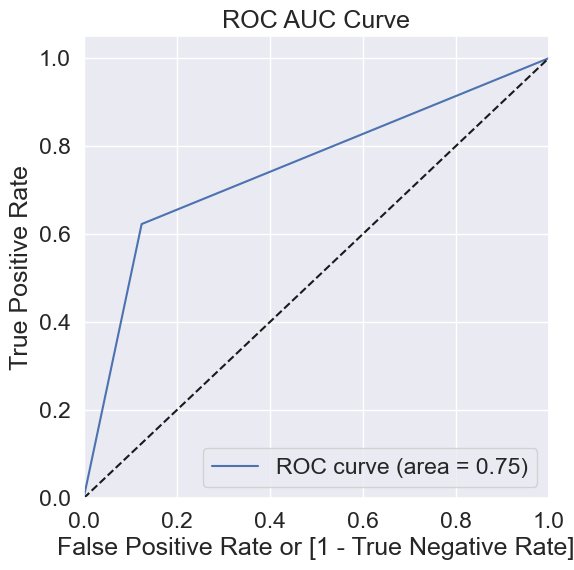

In [278]:
# ROC curve
fpr, tpr, thresholds = plot_roc(y_val, y_val_pred)

### Model 6 : XGBoost Classifier

In [281]:
# Create a pipeline
pipe = make_pipeline(
    smote,
    scaler,
    pca,
    XGBClassifier(random_state=42)
)

In [282]:
# Define hyperparameters for grid search
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],  
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
}

In [284]:
# Instantiate XG Boost GridSearchCV
xg_grid_search = GridSearchCV(
                            pipe, 
                            param_grid, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1, verbose=1)

In [285]:
%%time
# Train the model
xg_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: total: 25.3 s
Wall time: 54.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=26)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eva...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
                         'xgbclassifier__max_depth': [3, 5, 7],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [286]:
# Get the best parameters
best_params = xg_grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
xg_best_model = xg_grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = xg_best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = xg_best_model.predict(X_val)

Best Parameters: {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 300}


In [287]:
# Evaluating the train set
classification_metrics_calculator(y_train, y_train_pred)

Confusion Matrix

 [[15397     3]
 [    0  1398]]


Metric   Value
0             Accuracy  0.9998
1          Sensitivity  1.0000
2          Specificity  0.9998
3            Precision  0.9979
4  False Positive Rate  0.0002
5   True Positive Rate  1.0000

In [288]:
# Evaluating on test set
classification_metrics_calculator(y_val, y_val_pred)

Confusion Matrix

 [[3381  482]
 [ 127  210]]


Metric   Value
0             Accuracy  0.8550
1          Sensitivity  0.6231
2          Specificity  0.8752
3            Precision  0.3035
4  False Positive Rate  0.1248
5   True Positive Rate  0.6231

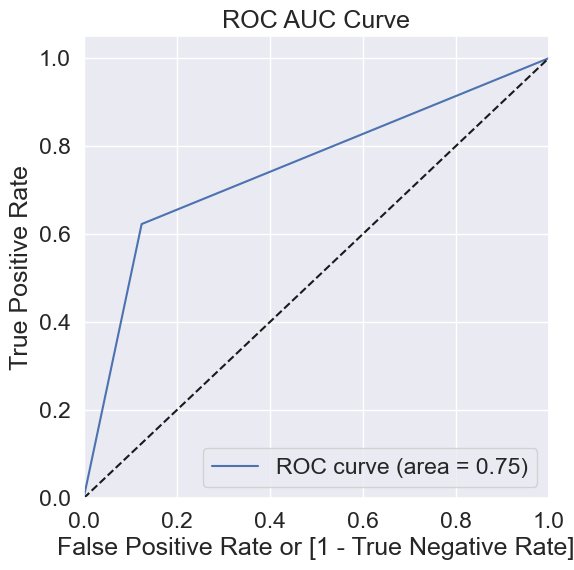

In [289]:
# ROC curve
fpr, tpr, thresholds = plot_roc(y_val, y_val_pred)

# Section 4 : Creating submission file

In [293]:
submission_df = final_test_df[selected_features]
submission_df.shape

(30000, 20)

In [333]:
final_test_df['churn_probability'] = logreg.predict(submission_df)
output = final_test_df['churn_probability']
output.head()

id
69999    0
70000    0
70001    1
70002    0
70003    0
Name: churn_probability, dtype: int64

In [334]:
output.to_csv('submission.csv', index=True)

# Section 5: Business Recommendations:

Based on the insights derived from the logistic regression model using Recursive Feature Elimination (RFE), the following strategies are recommended to reduce customer churn:

1. Personalized Roaming Offers: Create customized roaming packages for customers who frequently use roaming services to increase their retention.
2. Local Call Promotions: Introduce competitive pricing plans and bonus schemes for local calls to encourage higher usage and reduce churn.
3. Targeted Data Recharge Campaigns: Design marketing campaigns aimed at promoting data recharge packages, especially for high-data users, to enhance engagement and reduce churn probability.
4. High-Value Recharge Incentives: Offer loyalty-based discounts or incentives for customers who consistently perform high-value recharges, thereby improving retention among high-value customers.
5. Loyalty Programs: Implement customer loyalty programs with personalized offers based on usage patterns to keep users engaged with the service.
6. Retention Campaigns: Focus on re-engagement strategies such as special promotions for customers who exhibit low recharge activity, to bring them back into active use.
7. Promotions for Non-Data Users: Encourage non-data users to adopt data services by offering attractive introductory bundles that combine data with other services.
8. Night Pack Promotions: Revitalize night pack usage by introducing innovative night-time offers and bundles to attract customers who prefer off-peak usage periods.

By executing these strategies, telecom providers can effectively reduce churn rates and improve overall customer retention.

## Summary
After testing a variety of models, including Logistic Regression with Recursive Feature Elimination (RFE), Logistic Regression with hyperparameter tuning, Principal Component Analysis (PCA), Decision Trees, Random Forest, Adaboost, and XGBoost classifiers, the analysis indicates that Logistic Regression with PCA consistently delivers the best performance, particularly in terms of sensitivity on both the training and validation sets.

The primary objective in this telecom churn analysis is to minimize churn, making sensitivity—the ability to accurately identify churners—a crucial metric. Logistic Regression with PCA showed the highest sensitivity, making it the most reliable model for predicting churn. Other models, despite high accuracy during training, exhibited overfitting and underperformed on the test set.

In conclusion, Logistic Regression with PCA is the most appropriate model for churn prediction in this case. It balances performance and generalization, making it the optimal choice to drive business decisions focused on customer retention.

# Section 6: Important features - Logistic Regression with PCA

In [337]:
feature_coeff = lr_best_estimator.named_steps['logisticregression'].coef_
feature_coeff  # feature_coeff[0].ndim -> 1D, feature_coeff.ndim -> 2D

array([[ 0.0387428 , -0.34565722,  0.36769091,  0.08419359,  0.1285124 ,
        -0.04035335,  0.23875799, -0.38749951, -0.10046327, -0.17142806,
         0.10173136, -0.13904591,  0.03718278, -0.0726774 , -0.06352468,
        -0.04664704,  0.11300301, -0.24326294,  0.0162437 , -0.10035133]])

In [343]:
for num, com in enumerate(feature_coeff[0]):
    print(f'PC{num+1} : {com}')

PC1 : 0.038742798585592056
PC2 : -0.345657217820075
PC3 : 0.36769091321394026
PC4 : 0.08419359279626104
PC5 : 0.12851239794072292
PC6 : -0.040353345347830444
PC7 : 0.2387579939590657
PC8 : -0.38749951015405115
PC9 : -0.10046327078330677
PC10 : -0.17142806156180884
PC11 : 0.10173136320466544
PC12 : -0.13904591014737055
PC13 : 0.03718277797026115
PC14 : -0.07267739659976412
PC15 : -0.06352467686225063
PC16 : -0.046647038726937824
PC17 : 0.1130030149124388
PC18 : -0.24326294137981458
PC19 : 0.01624370453523943
PC20 : -0.10035132746484597


<pre>
------------------------------------------------------------------------------------

<pre>
------------------------------------------------------------------------------------

#### Trying a few models to validate the accuracy score of unseen set on Kaggle

In [348]:
# XGBoost
submission_df2 = final_test_df.drop(columns=['churn_probability'])
final_test_df['churn_probability'] = xg_best_model.predict(submission_df2)
output_2 = final_test_df[['churn_probability']] # final_test_df[['churn_probability']]: 
                                                #This will return a DataFrame with a single column, 
                                                # keeping it in a 2-dimensional structure.
                                                # final_test_df['churn_probability']: 
                                                # This will return a Series, which is a 1-dimensional object.
output_2.to_csv('submission_2.csv', index=True)

In [346]:
final_test_df.shape

(30000, 155)

In [369]:
# Logistic Reg with 25 features
submission_df_25 = final_test_df[selected_features_25]
submission_df_25.shape


(30000, 25)

In [370]:
final_test_df['churn_probability'] = logreg_25.predict(submission_df_25)
output_25 = final_test_df['churn_probability']
output_25.head()

id
69999    0
70000    0
70001    1
70002    0
70003    0
Name: churn_probability, dtype: int64

In [371]:
output_25.to_csv('submission_lr_25.csv', index=True)

In [373]:
# Random Forest

submission_df_rf = final_test_df.drop(columns=['churn_probability'])
final_test_df['churn_probability'] = rf_grid_search.predict(submission_df_rf)
output_rf = final_test_df[['churn_probability']] # final_test_df[['churn_probability']]: 
                                                #This will return a DataFrame with a single column, 
                                                # keeping it in a 2-dimensional structure.
                                                # final_test_df['churn_probability']: 
                                                # This will return a Series, which is a 1-dimensional object.
output_rf.to_csv('submission_rf.csv', index=True)